In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

from mpmath import polylog

from sklearn.model_selection import train_test_split

In [ ]:
def generate_data(func, lower=0, upper=1, n_samples=100):
    """
        Generates data in the form of a 2D (1D in case if the function 
        is single-variable) tensor of variables for fuction and neural network input
        as well as te function values for the generated tensor of variables.

        @param func      function to provide values for the variables
        @param lower     lower bound of variables
        @param upper     upper bound of variables
        @param n_samples number of points of data to generate
                         (default value is 100)

        @returns         variables x and function values y
    """
    x = torch.linspace(lower, upper, n_samples).view(n_samples, 1) # 1 for 1d functions
    y = func(x)
    
    return x, y

In [ ]:
class MLP(nn.Module):
    """
        Нейросеть, которая будет обучаться приближать функцию одной переменной.
        
        Нейросеть имеет архитектуру:

        Входной слой (1 нейрон для переменной функции + смещение, линейная функция активации)
        Скрытый слой (произвольное количество нейронов + смещение, функция активации - сигмоида)
        Выходной слой (1 нейрон для приближенного значения функции, линейная функция активации)
    """
    def __init__(self, hidden_size):
        """
            Конструктор для нейросети.
            @param self        нейросеть (необходим для включения в класс)
            @param hidden_size размер скрытого слоя (размеры входного и выходного слоёв равны одному
                               в рамках данной задачи, так как у функции одна переменная и 
                               задача сводится к описанию функции, то есть числа, скаляра).
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(1, hidden_size) # инициализация входного и скрытого слоя, 
                                                     # размеры: 1 --> размер скрытого слоя
        self.sigmoid_activation = nn.Sigmoid() # инициализация функции активации скрытого слоя
        self.output_layer = nn.Linear(hidden_size, 1) # инициализация выходного слоя, 
                                                      # размеры: размер скрытого слоя --> 1
    
    def forward(self, x):
        """
            Функция распространения данных через нейросеть вперёд.
           
            @param self   нейросеть (необходим для включения в класс)
            @param x      данные
           
            @returns выход в выходном нейроне
        """
        x = self.input_hidden_layer(x) # данные прошли входной слой и аккумулирвоаны в скрытом слое
        x = self.sigmoid_activation(x) # данные прошли функцию активации скрытого слоя
        x = self.output_layer(x) # данные прошли выходной слой
        
        return x


def train_model(model, criterion, optimizer, x_train, y_train, epochs):
    """
        Trains the model.
        
        @param model        The model to be trained
        @param criterion    Loss function
        @param optimizer    Optimization algorithm
        @param x_train      Training inputs
        @param y_train      True labels
        @param epochs       Number of training epochs
    """
    loss_history = [] # история обучения (изменения функции потерь)
    for epoch in range(epochs):
        predictions = model(x_train) # все переменные проводятся через нейросеть 
                                     # и формируются предскзания значений функции
        loss = criterion(predictions, y_train) # вычисляется функция потерь на данной эпохе

        optimizer.zero_grad() # обнуляются градиенты перед обратным распространением ошибки
        loss.backward() # обратное распространение ошибки
        optimizer.step() # шаг оптимизации - обновление параметров модели 

        loss_history.append(loss.item()) # запись текущей функции потерь

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}') # вывод информации об обучении
    
    return loss_history # возвращается история обучения


def test_model(model, criterion, x_test, y_test):
    """
        Tests the model.
        
        @param model        The trained model
        @param criterion    Loss function
        @param x_test       Test inputs
        @param y_test       True labels
    """
    with torch.no_grad():  # отключение расчета градиентов 
                           # (расчет градиентов может происходить по умолчанию 
                           # даже без использования их потом, что излишне нагружает память)
        predictions = model(x_test)  # тестовые переменные проводятся через обученную модель
        loss = criterion(predictions, y_test)  # вычисляется функция потерь для тестового набора

    # Возвращаем вычисленную функцию потерь
    return loss.item()  # Возвращаем скалярное значение ошибки


def predict_with_model(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.
    
        @param model        The trained model
        @param x_test       Test inputs
    """
    with torch.no_grad():
        predictions = model(x_test)

    return predictions


def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy().flatten()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

# Integration function

In [ ]:
def get_NN_integral(alpha, beta, b1, w1, b2, w2):
    """
        Функция, реализующая метод численного интегрирования функции одной переменной
        на основе параметров нейросети. Реализует формулы (6.1) и (6.2).

        @param alpha нижняя граница интегрирования
        @param beta  верхняя граница интегрирования
        @param b1    смещения между входным и скрытым слоями
        @param w1    веса между входным и скрытым слоями
        @param b2    смещения между скрытым и выходным слоями
        @param w2    веса между скрытым и выходным слоями

        @returns численный интеграл на основе параметров нейросети.
    """
    def Phi_j(alpha, beta, b1_j, w1_j):
        """
            Вложенная функция, реализующая разность полилогарифмов (6.2).

            @param alpha нижняя граница интегрирования
            @param beta  верхняя граница интегрирования
            @param b1_j  j-е смещение между входным и скрытым слоями
            @param w1_j  j-тый вес между входным и скрытым слоями

            @returns разность полилогарифмов (6.2)
        """
        term_alpha = polylog(1, -np.exp(-b1_j - w1_j * alpha)) # расчет первого полилогарифма 1-го порядка
        term_beta = polylog(1, -np.exp(-b1_j - w1_j * beta)) # расчет второго полилогарифма 1-го порядка
        
        return term_alpha - term_beta # результат - разность первого и второго полилогарифмов

    integral_sum = 0 # сумма интеграллов 
    
    for w2_j, w1_j, b1_j in zip(w2, w1, b1):
        phi_j = Phi_j(alpha, beta, b1_j, w1_j) # рассчет разности полилогарифмов (6.2)
        integral_sum += w2_j * ((beta - alpha) + phi_j / w1_j) # аккумулирование интегралла для суммы в (6.1)
    
    return b2 * (beta - alpha) + integral_sum # результат полная формула численног метода (6.1)

# Physics task: Definition

\begin{equation}
    \int_{0}^{1}d\alpha\{\alpha^{a}(1 - \alpha)^b\}\int_{0}^{\infty}dt\{\frac{t^m}{(1+t)^n}F[z_{0}]\} \equiv I(a, b, m, n; F[z_{0}])  \tag{1}
\end{equation}
\begin{equation}   
    F[z_0] = \exp[-2z_0]  \tag{2}
\end{equation}
\begin{equation} 
    z_0 = tD + \frac{t}{1 + t}R^2  \tag{3}
\end{equation}
\begin{equation}     
    D = \alpha_1(b_1^{2}P^2 + m_1^2) + \alpha_2(b_2^{2}P^2 + m_2^2)  \tag{4}
\end{equation}
\begin{equation} 
        R^2 = (\alpha_1^{2}b_1^2 + \alpha_2^{2}b_2^2 + 2\alpha_{1}\alpha_{2}b_{1}b_2)P^2  \tag{5}
\end{equation}
\begin{equation} 
    b_1 = -\frac{m_1}{m_1 + m_2}  \tag{6}
\end{equation}
\begin{equation} 
    b_2 = \frac{m_2}{m_1 + m_2}  \tag{7}
\end{equation}
\begin{equation} 
    m_1 = m_2 = 0.7083333, P^2 = -1.665046  \tag{8}
\end{equation}

## Constants: general

These constants will be used for all of the calculations.

In [ ]:
la = 0.8550000
# la = 1/137
alpha1 = alpha2 = la
m1 = 0.7083333
m2 = 0.7083333
PP = -1.665046

## First factor function

\begin{equation}
    \alpha^{a}(1 - \alpha)^b\ \tag{1.1}
\end{equation}

In [ ]:
def alpha_func(alpha):
    return alpha ** a_ * (1 - alpha) ** b_

## Second factor function

\begin{equation}
   \frac{t^m}{(1+t)^n}F[z_{0}]  \tag{1.2}
\end{equation}

As far as the integral function converges quickly the infinite upper bound of integration will be replaced with a constant. Later we will decide which constant to choose.

In [ ]:
def b1_func():
    return - m1 / (m1 + m2)

def b2_func():
    return m2 / (m1 + m2)

def D_func():
    b1b1 = b1_func() ** 2
    b2b2 = b2_func() ** 2
    
    return alpha1 * (b1b1 * PP + m1**2) + alpha2 * (b2b2 * PP + m2**2)

def RR_func():
    b1 = b1_func()
    b2 = b2_func()
    b1b1 = b1 ** 2
    b2b2 = b2 ** 2
    
    return (alpha1**2 * b1b1 + alpha2**2 * b2b2 + 2 * alpha1 * alpha2 * b1 * b2) * PP

def z0_func(t):
    D = D_func()
    RR = RR_func()
    return t * D + t / (1 + t) * RR

def F_func(t):
    z_0 = z0_func(t)
    return np.exp(-2*z_0)

def t_func(t):
    return (t ** m_) / ((1 + t) ** n_) * F_func(t)

## Second factor function: addition

The further computation will require a derivative of the (2) function, so it should be declared here. The derivative is equal to

\begin{equation}
    F'[z_0] = -2\exp[-2z_0] \tag{9}
\end{equation}

In [ ]:
def F_derivative(t):
    return -2 * F_func(t)

def t_func_with_F_der(t):
    return t ** m_ / (1 + t) ** n_ * F_derivative(t)

# NN Integration: first run

The constants are:

In [ ]:
a_ = 0
b_ = 1
m_ = 2
n_ = 2

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

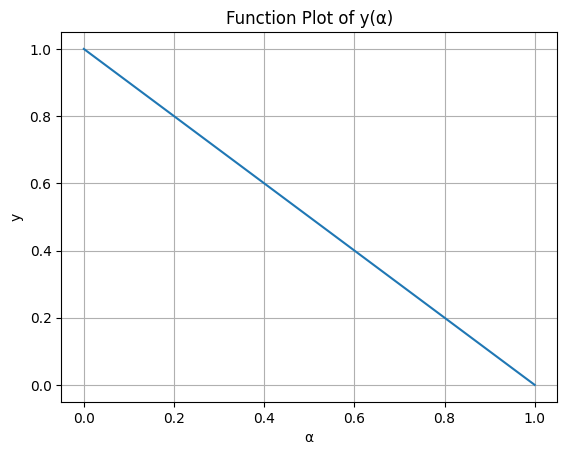

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

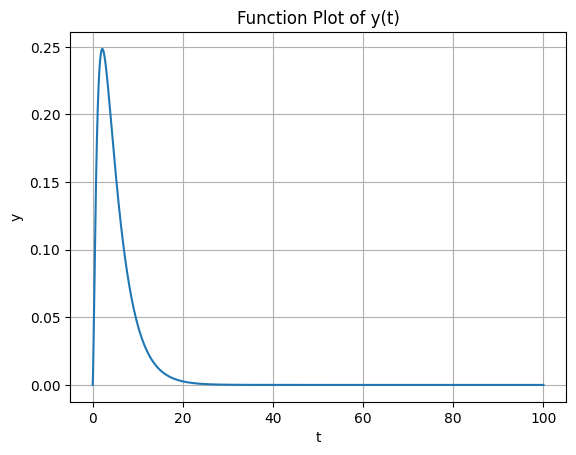

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=25, n_samples=2500)

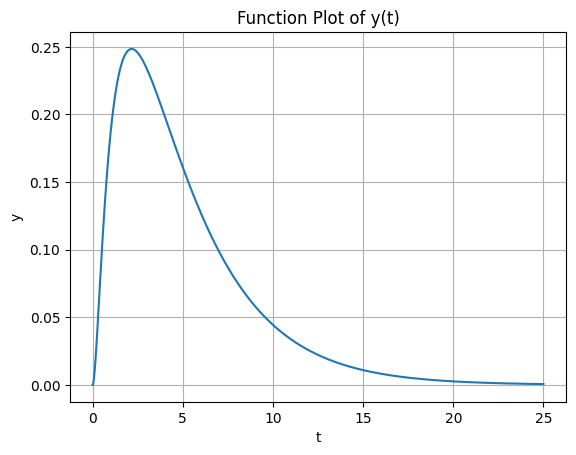

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
def find_upper_bound(X, y, epsilon, points_limit=1, lower_index=0):
    """
        Finds the upper bound of integration. In this case a point, 
        where the next function value is greater/lesser than the previous
        less than a given threshold.

        @param X            variable values
        @param y            function values
        @param epsilon      threshold
        @param points_limit limit of bound points number 
        @param lower_index  starting X value for the search
        
        @returns       the required variable values (can be many) 
                       or empty list if none found
    """
    X_points = []
    
    if len(X) != len(y):
        raise ValueError("There numbers of variable and function values are inequal!")
    
    for i in range(lower_index, len(y) - 1):
        diff = torch.abs(y[i] - y[i + 1])
        if diff < epsilon:
            X_points.append(X[i])
        if len(X_points) == points_limit:
            break
            
    return X_points

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([34.9635])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

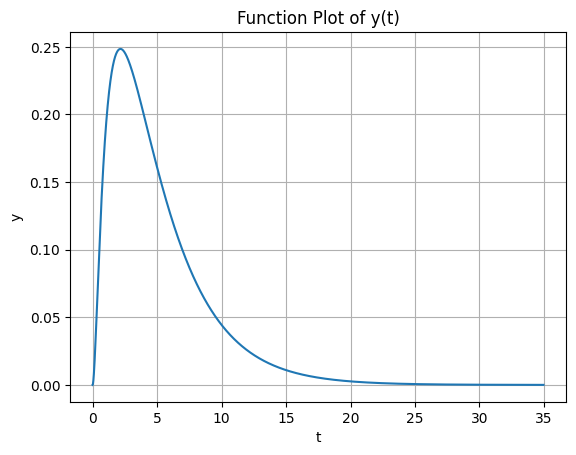

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 34.963497161865234)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

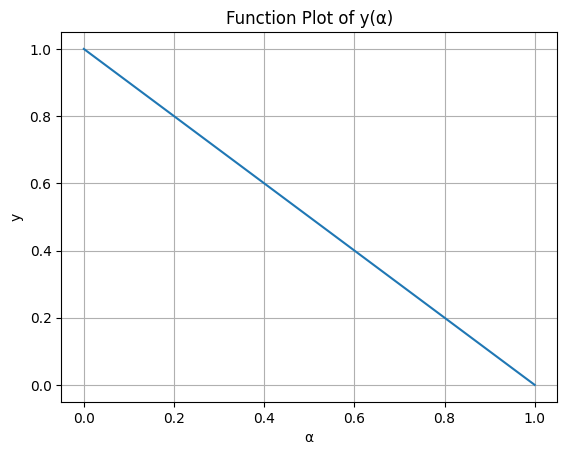

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

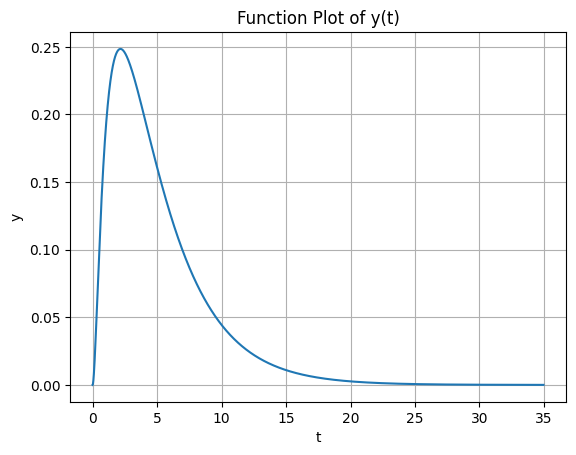

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

In [ ]:
# def normalize(X, y):
#     X_min = X.min()
#     X_max = X.max()
#     X_norm = (X - X_min) / (X_max - X_min)

#     y_min = y.min()
#     y_max = y.max()
#     y_norm = (y - y_min) / (y_max - y_min)

#     return X_norm, y_norm

In [ ]:
# T, t_y = normalize(T, t_y)

In [ ]:
# T_np = T.numpy()
# t_y_np = t_y.numpy()
# plt.plot(T_np, t_y_np)
# plt.xlabel('t')
# plt.ylabel('y')
# plt.title('Function Plot of y(t)')
# plt.grid(True)
# plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([3146, 1]),
 torch.Size([350, 1]),
 torch.Size([3146, 1]),
 torch.Size([350, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.0735880360
Epoch [200/10000], Loss: 0.0623271503
Epoch [300/10000], Loss: 0.0487404615
Epoch [400/10000], Loss: 0.0337734930
Epoch [500/10000], Loss: 0.0197716355
Epoch [600/10000], Loss: 0.0093506463
Epoch [700/10000], Loss: 0.0034631242
Epoch [800/10000], Loss: 0.0010078086
Epoch [900/10000], Loss: 0.0002528247
Epoch [1000/10000], Loss: 0.0000769231
Epoch [1100/10000], Loss: 0.0000441727
Epoch [1200/10000], Loss: 0.0000385107
Epoch [1300/10000], Loss: 0.0000369076
Epoch [1400/10000], Loss: 0.0000357727
Epoch [1500/10000], Loss: 0.0000346576
Epoch [1600/10000], Loss: 0.0000335200
Epoch [1700/10000], Loss: 0.0000323608
Epoch [1800/10000], Loss: 0.0000311842
Epoch [1900/10000], Loss: 0.0000299946
Epoch [2000/10000], Loss: 0.0000287967
Epoch [2100/10000], Loss: 0.0000275951
Epoch [2200/10000], Loss: 0.0000263945
Epoch [2300/10000], Loss: 0.0000251994
Epoch [2400/10000], Loss: 0.0000240145
Epoch [2500/10000], Loss: 0.0000228442
Epoch [2600/10000], Loss: 0.000021

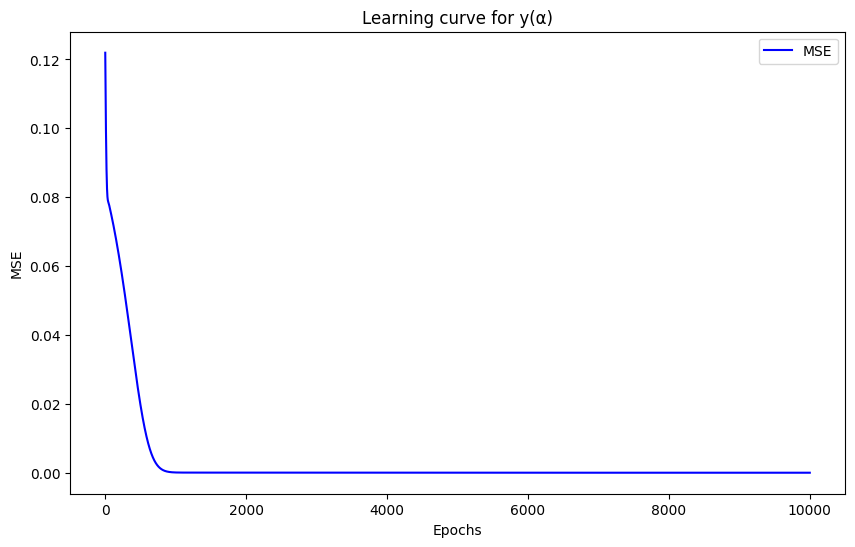

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000035599


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.49991009021605304')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{1 - \alpha\} = \alpha - \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return b - b**2/2 - (a - a**2/2)

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

8.990978394696203e-05

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0011274860
Epoch [200/5000], Loss: 0.0005428370
Epoch [300/5000], Loss: 0.0003782436
Epoch [400/5000], Loss: 0.0002935955
Epoch [500/5000], Loss: 0.0002264130
Epoch [600/5000], Loss: 0.0001706529
Epoch [700/5000], Loss: 0.0001253895
Epoch [800/5000], Loss: 0.0000901667
Epoch [900/5000], Loss: 0.0000638459
Epoch [1000/5000], Loss: 0.0000448199
Epoch [1100/5000], Loss: 0.0000314591
Epoch [1200/5000], Loss: 0.0000223007
Epoch [1300/5000], Loss: 0.0000161247
Epoch [1400/5000], Loss: 0.0000119878
Epoch [1500/5000], Loss: 0.0000092129
Epoch [1600/5000], Loss: 0.0000073404
Epoch [1700/5000], Loss: 0.0000060649
Epoch [1800/5000], Loss: 0.0000051819
Epoch [1900/5000], Loss: 0.0000045531
Epoch [2000/5000], Loss: 0.0000040852
Epoch [2100/5000], Loss: 0.0000037174
Epoch [2200/5000], Loss: 0.0000034115
Epoch [2300/5000], Loss: 0.0000031449
Epoch [2400/5000], Loss: 0.0000029050
Epoch [2500/5000], Loss: 0.0000026854
Epoch [2600/5000], Loss: 0.0000024831
Epoch [2700/5000], Lo

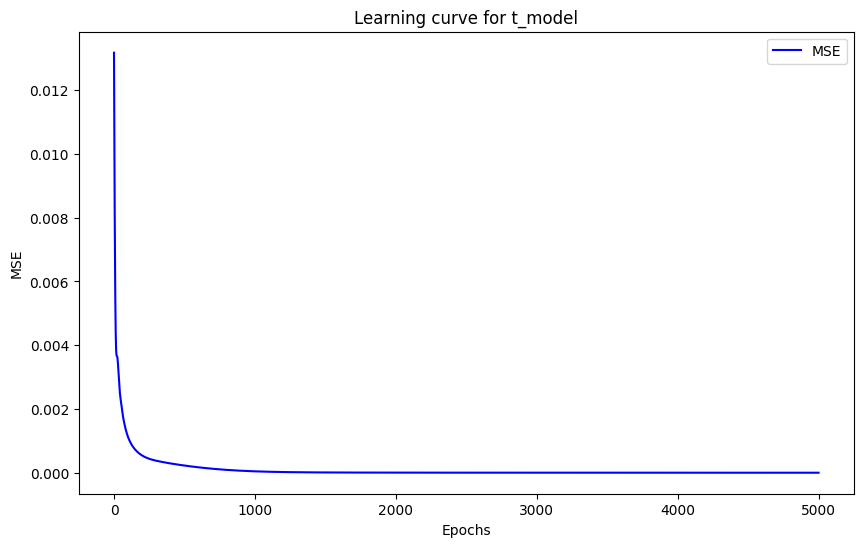

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000006758


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('1.580750372773323')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 1

In [ ]:
result1 = nn_alpha * nn_t

result1

0.7902330614621713

In [ ]:
correct_result1 = 0.7724590
error_for_result1 = abs(result1 - correct_result1)
error_for_result1

0.01777406146217131

# NN Integration: second run

The constants are:

In [ ]:
a_ = 0
b_ = 1
m_ = 3
n_ = 3

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

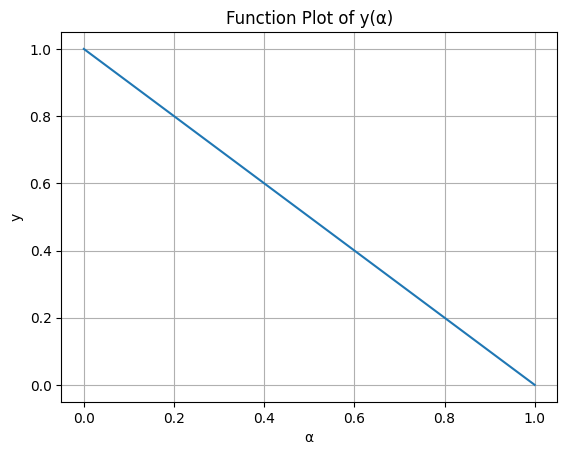

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

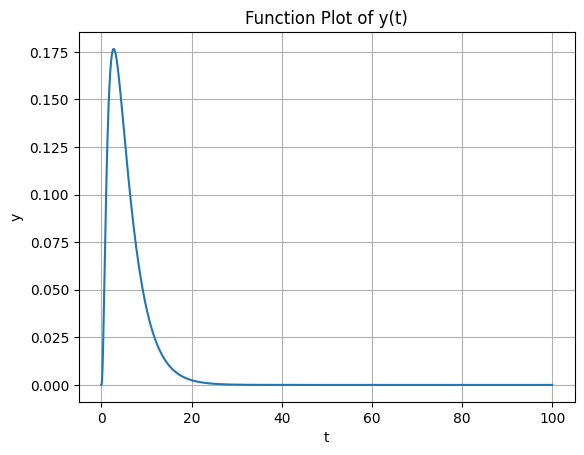

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

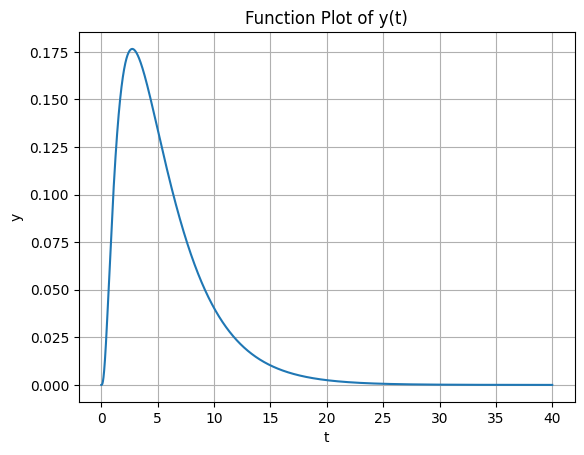

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
def find_upper_bound(X, y, epsilon, points_limit=1, lower_index=0):
    """
        Finds the upper bound of integration. In this case a point, 
        where the next function value is greater/lesser than the previous
        less than a given threshold.

        @param X            variable values
        @param y            function values
        @param epsilon      threshold
        @param points_limit limit of bound points number 
        @param lower_index  starting X value for the search
        
        @returns       the required variable values (can be many) 
                       or empty list if none found
    """
    X_points = []
    
    if len(X) != len(y):
        raise ValueError("There numbers of variable and function values are inequal!")
    
    for i in range(lower_index, len(y) - 1):
        diff = torch.abs(y[i] - y[i + 1])
        if diff < epsilon:
            X_points.append(X[i])
        if len(X_points) == points_limit:
            break
            
    return X_points

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([34.8535])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

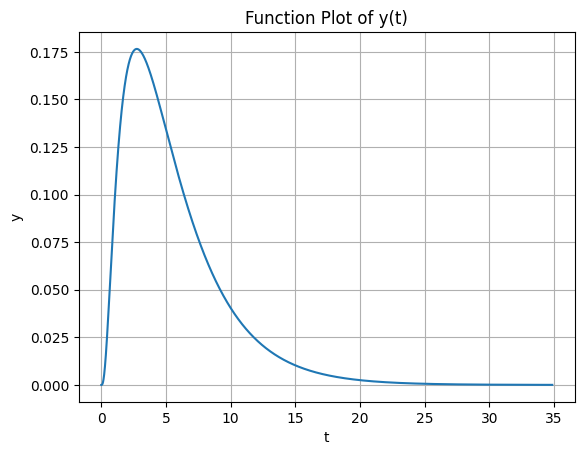

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 34.853485107421875)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

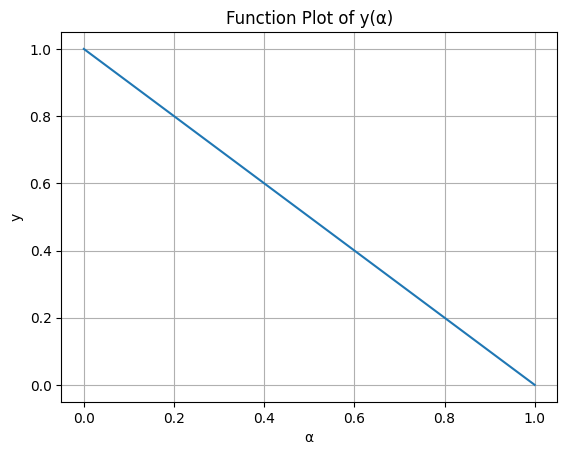

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

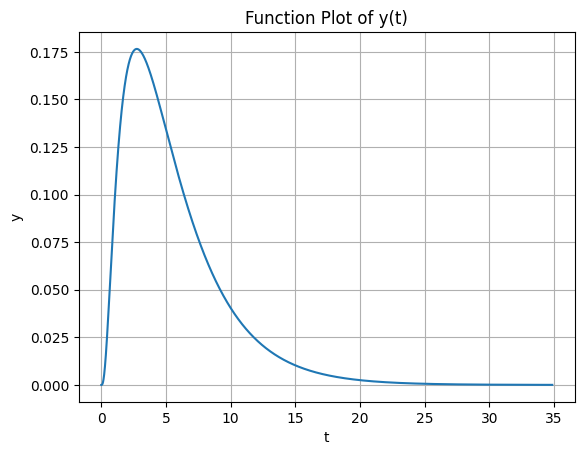

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([3136, 1]),
 torch.Size([349, 1]),
 torch.Size([3136, 1]),
 torch.Size([349, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.2529495358
Epoch [200/10000], Loss: 0.1012888029
Epoch [300/10000], Loss: 0.0893656611
Epoch [400/10000], Loss: 0.0848986655
Epoch [500/10000], Loss: 0.0802198946
Epoch [600/10000], Loss: 0.0752831772
Epoch [700/10000], Loss: 0.0701370239
Epoch [800/10000], Loss: 0.0648185685
Epoch [900/10000], Loss: 0.0593621954
Epoch [1000/10000], Loss: 0.0538061894
Epoch [1100/10000], Loss: 0.0481971055
Epoch [1200/10000], Loss: 0.0425921604
Epoch [1300/10000], Loss: 0.0370598324
Epoch [1400/10000], Loss: 0.0316787511
Epoch [1500/10000], Loss: 0.0265352130
Epoch [1600/10000], Loss: 0.0217189658
Epoch [1700/10000], Loss: 0.0173173398
Epoch [1800/10000], Loss: 0.0134074427
Epoch [1900/10000], Loss: 0.0100469077
Epoch [2000/10000], Loss: 0.0072651072
Epoch [2100/10000], Loss: 0.0050571682
Epoch [2200/10000], Loss: 0.0033835021
Epoch [2300/10000], Loss: 0.0021757982
Epoch [2400/10000], Loss: 0.0013481331
Epoch [2500/10000], Loss: 0.0008101861
Epoch [2600/10000], Loss: 0.000478

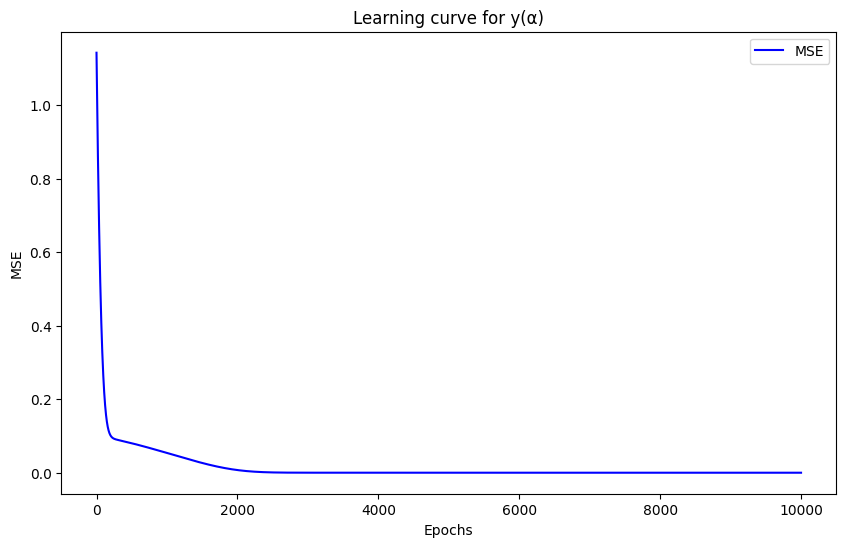

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000112666


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.49996008951780746')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{1 - \alpha\} = \alpha - \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return b - b**2/2 - (a - a**2/2)

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

3.991048219254001e-05

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.1938060969
Epoch [200/5000], Loss: 0.0373383239
Epoch [300/5000], Loss: 0.0152366320
Epoch [400/5000], Loss: 0.0109981149
Epoch [500/5000], Loss: 0.0083619850
Epoch [600/5000], Loss: 0.0060598352
Epoch [700/5000], Loss: 0.0037957898
Epoch [800/5000], Loss: 0.0016830387
Epoch [900/5000], Loss: 0.0009111717
Epoch [1000/5000], Loss: 0.0007311995
Epoch [1100/5000], Loss: 0.0006380520
Epoch [1200/5000], Loss: 0.0005640443
Epoch [1300/5000], Loss: 0.0004987911
Epoch [1400/5000], Loss: 0.0004402455
Epoch [1500/5000], Loss: 0.0003876530
Epoch [1600/5000], Loss: 0.0003404667
Epoch [1700/5000], Loss: 0.0002982093
Epoch [1800/5000], Loss: 0.0002604601
Epoch [1900/5000], Loss: 0.0002268501
Epoch [2000/5000], Loss: 0.0001970543
Epoch [2100/5000], Loss: 0.0001707815
Epoch [2200/5000], Loss: 0.0001477614
Epoch [2300/5000], Loss: 0.0001277341
Epoch [2400/5000], Loss: 0.0001104414
Epoch [2500/5000], Loss: 0.0000956213
Epoch [2600/5000], Loss: 0.0000830069
Epoch [2700/5000], Lo

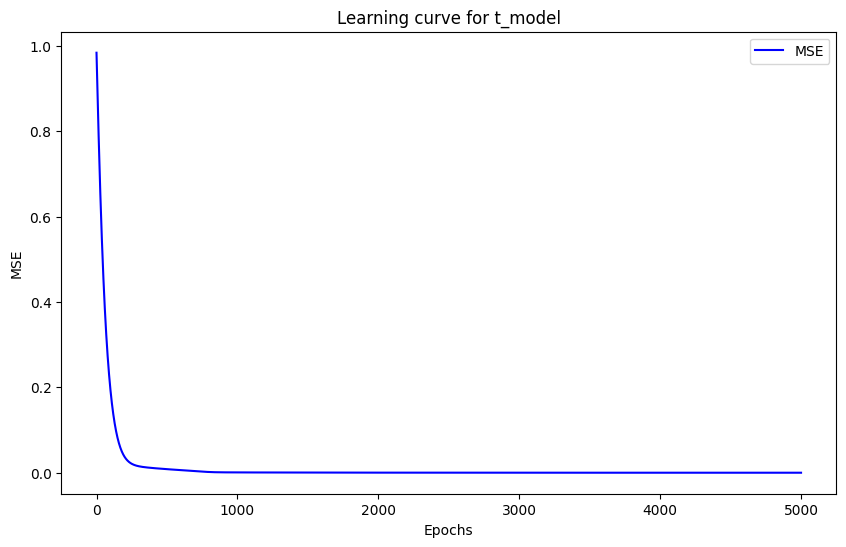

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000123485


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('1.2107405436129479')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 2

In [ ]:
result2 = nn_alpha * nn_t

result2

0.6053219505675683

In [ ]:
correct_result2 = 0.5979058
error_for_result2 = abs(result2 - correct_result2)
error_for_result2

0.00741615056756828

# NN Integration: third run

The constants are:

In [ ]:
a_ = 0
b_ = 1
m_ = 4
n_ = 4

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

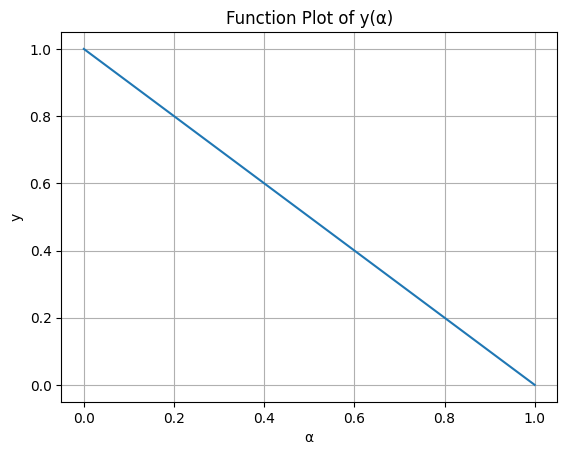

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

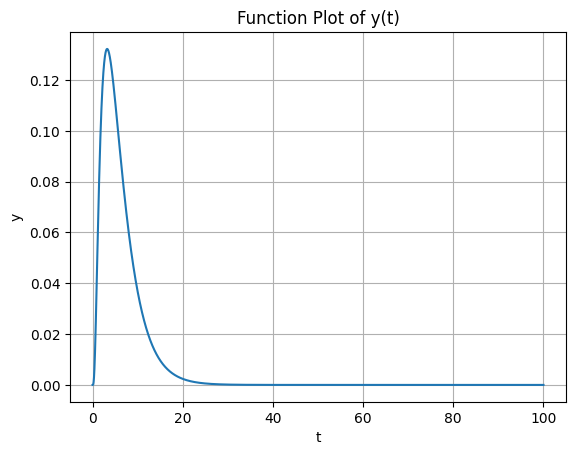

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

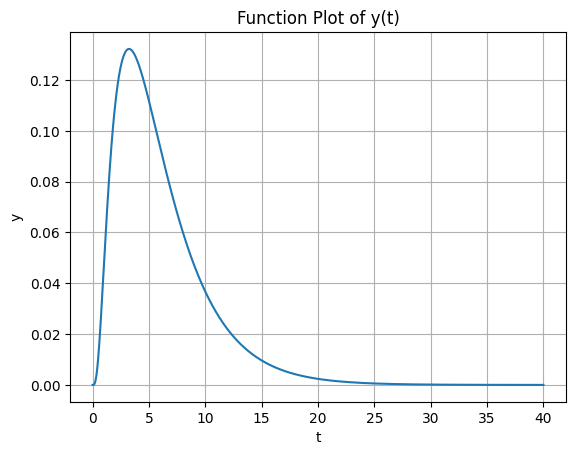

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([34.7535])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

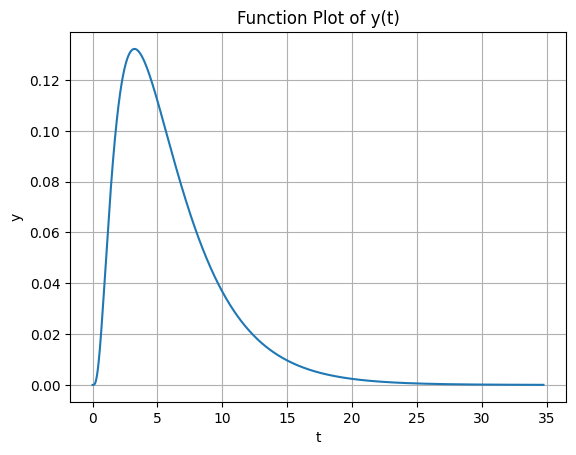

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 34.753475189208984)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

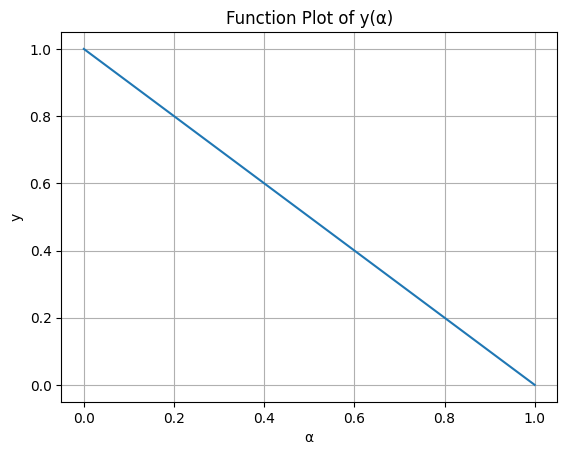

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

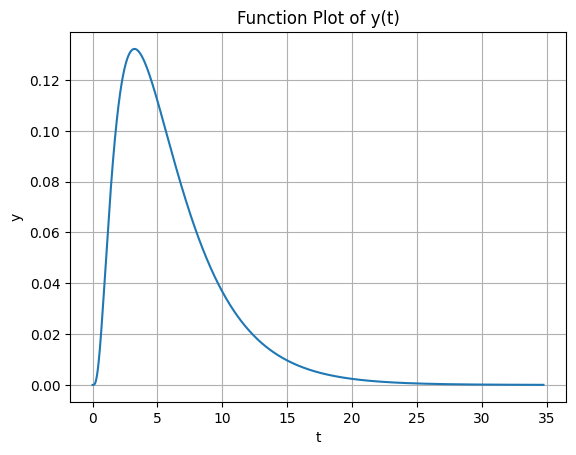

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([3127, 1]),
 torch.Size([348, 1]),
 torch.Size([3127, 1]),
 torch.Size([348, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.0822044909
Epoch [200/10000], Loss: 0.0714152753
Epoch [300/10000], Loss: 0.0612149574
Epoch [400/10000], Loss: 0.0510101095
Epoch [500/10000], Loss: 0.0408752151
Epoch [600/10000], Loss: 0.0311066099
Epoch [700/10000], Loss: 0.0221721567
Epoch [800/10000], Loss: 0.0145919146
Epoch [900/10000], Loss: 0.0087560294
Epoch [1000/10000], Loss: 0.0047604032
Epoch [1100/10000], Loss: 0.0023661307
Epoch [1200/10000], Loss: 0.0011217183
Epoch [1300/10000], Loss: 0.0005606831
Epoch [1400/10000], Loss: 0.0003388402
Epoch [1500/10000], Loss: 0.0002596124
Epoch [1600/10000], Loss: 0.0002319599
Epoch [1700/10000], Loss: 0.0002205272
Epoch [1800/10000], Loss: 0.0002135140
Epoch [1900/10000], Loss: 0.0002074840
Epoch [2000/10000], Loss: 0.0002015627
Epoch [2100/10000], Loss: 0.0001955630
Epoch [2200/10000], Loss: 0.0001894596
Epoch [2300/10000], Loss: 0.0001832612
Epoch [2400/10000], Loss: 0.0001769828
Epoch [2500/10000], Loss: 0.0001706408
Epoch [2600/10000], Loss: 0.000164

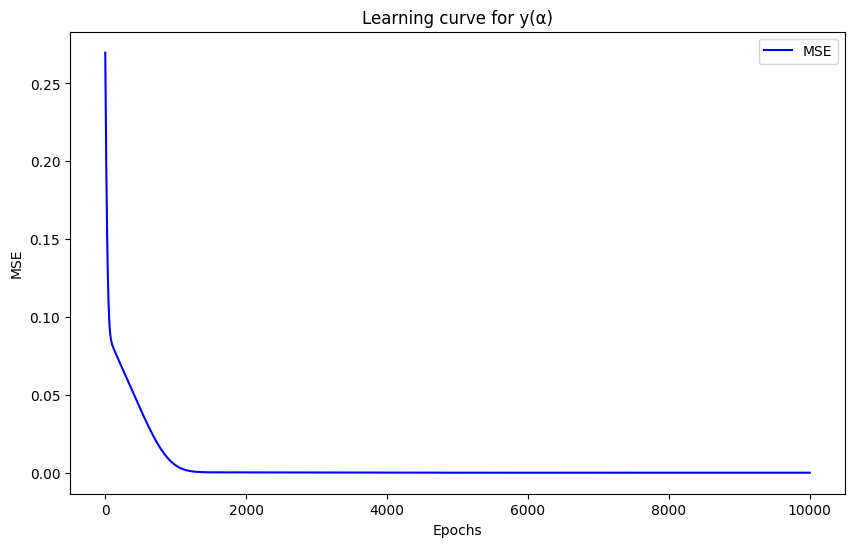

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000054359


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.50003211437535378')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{1 - \alpha\} = \alpha - \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return b - b**2/2 - (a - a**2/2)

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

3.211437535377559e-05

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0015917721
Epoch [200/5000], Loss: 0.0005843511
Epoch [300/5000], Loss: 0.0003227717
Epoch [400/5000], Loss: 0.0002143744
Epoch [500/5000], Loss: 0.0001525990
Epoch [600/5000], Loss: 0.0001138812
Epoch [700/5000], Loss: 0.0000895771
Epoch [800/5000], Loss: 0.0000736556
Epoch [900/5000], Loss: 0.0000622367
Epoch [1000/5000], Loss: 0.0000531691
Epoch [1100/5000], Loss: 0.0000454508
Epoch [1200/5000], Loss: 0.0000386780
Epoch [1300/5000], Loss: 0.0000326826
Epoch [1400/5000], Loss: 0.0000273748
Epoch [1500/5000], Loss: 0.0000227021
Epoch [1600/5000], Loss: 0.0000186380
Epoch [1700/5000], Loss: 0.0000151667
Epoch [1800/5000], Loss: 0.0000122678
Epoch [1900/5000], Loss: 0.0000099060
Epoch [2000/5000], Loss: 0.0000080298
Epoch [2100/5000], Loss: 0.0000065759
Epoch [2200/5000], Loss: 0.0000054751
Epoch [2300/5000], Loss: 0.0000046593
Epoch [2400/5000], Loss: 0.0000040660
Epoch [2500/5000], Loss: 0.0000036411
Epoch [2600/5000], Loss: 0.0000033399
Epoch [2700/5000], Lo

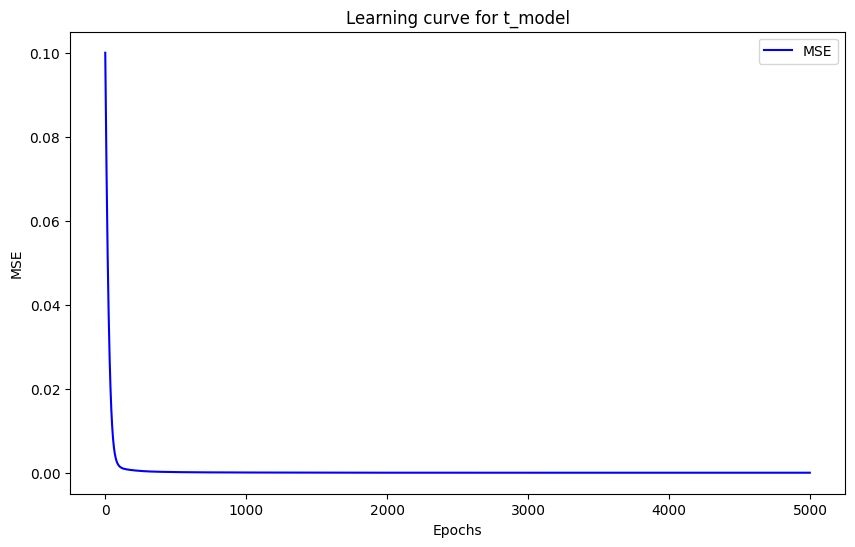

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000013523


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('0.95826352579131147')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 3

In [ ]:
result3 = nn_alpha * nn_t

result3

0.4791625369302108

In [ ]:
correct_result3 = 0.4794361
error_for_result3 = abs(result3 - correct_result3)
error_for_result3

0.0002735630697891511

# NN Integration: forth run

The constants are:

In [ ]:
a_ = 1
b_ = 0
m_ = 2
n_ = 2

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

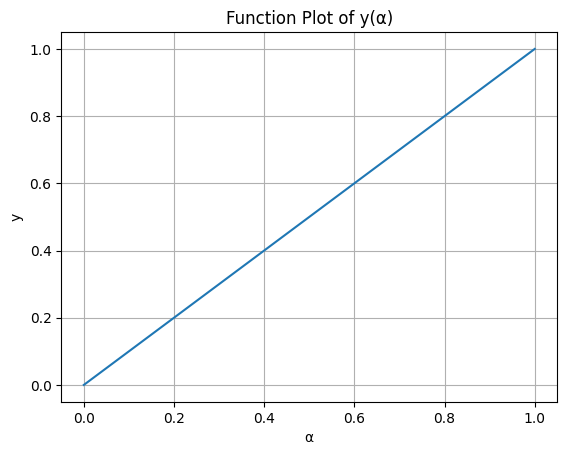

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

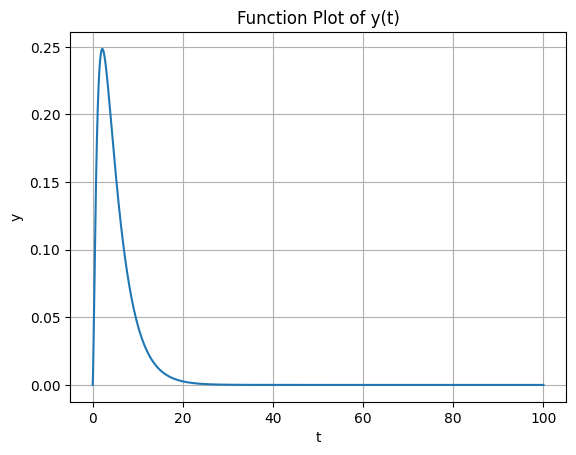

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

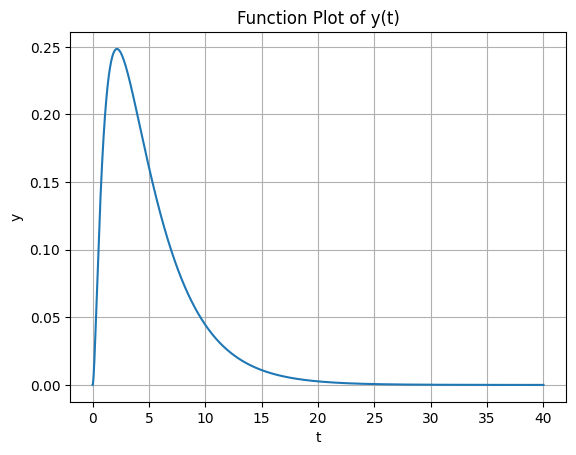

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([34.9635])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

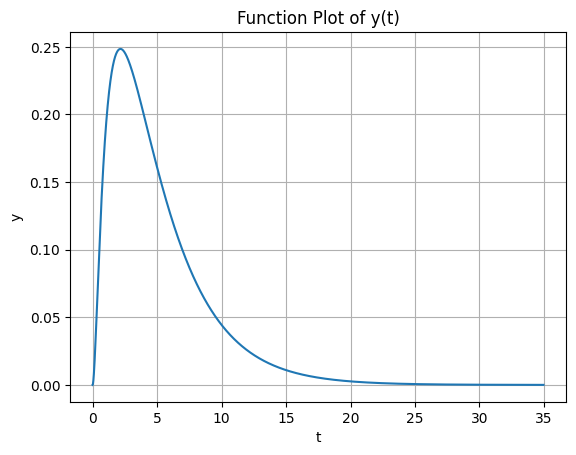

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 34.963497161865234)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

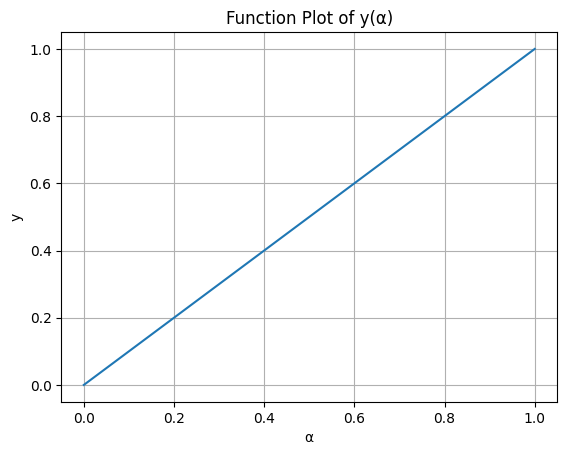

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

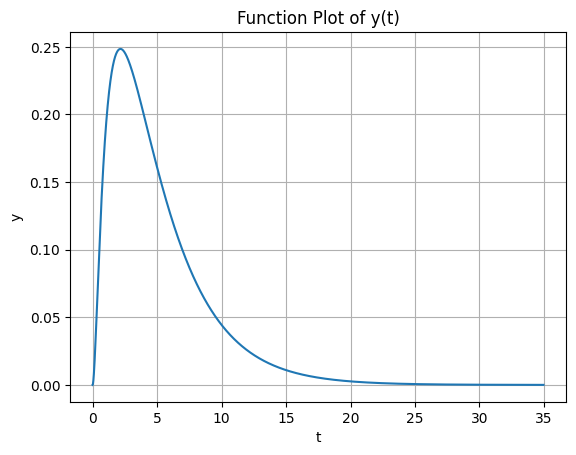

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([3146, 1]),
 torch.Size([350, 1]),
 torch.Size([3146, 1]),
 torch.Size([350, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.2513090372
Epoch [200/10000], Loss: 0.0891676247
Epoch [300/10000], Loss: 0.0745375752
Epoch [400/10000], Loss: 0.0702863336
Epoch [500/10000], Loss: 0.0659412891
Epoch [600/10000], Loss: 0.0613604262
Epoch [700/10000], Loss: 0.0565481596
Epoch [800/10000], Loss: 0.0514887646
Epoch [900/10000], Loss: 0.0461643822
Epoch [1000/10000], Loss: 0.0405755714
Epoch [1100/10000], Loss: 0.0347628929
Epoch [1200/10000], Loss: 0.0288292989
Epoch [1300/10000], Loss: 0.0229583234
Epoch [1400/10000], Loss: 0.0174101423
Epoch [1500/10000], Loss: 0.0124758529
Epoch [1600/10000], Loss: 0.0083977608
Epoch [1700/10000], Loss: 0.0052946727
Epoch [1800/10000], Loss: 0.0031334546
Epoch [1900/10000], Loss: 0.0017591889
Epoch [2000/10000], Loss: 0.0009608779
Epoch [2100/10000], Loss: 0.0005356303
Epoch [2200/10000], Loss: 0.0003262581
Epoch [2300/10000], Loss: 0.0002294944
Epoch [2400/10000], Loss: 0.0001861114
Epoch [2500/10000], Loss: 0.0001658846
Epoch [2600/10000], Loss: 0.000154

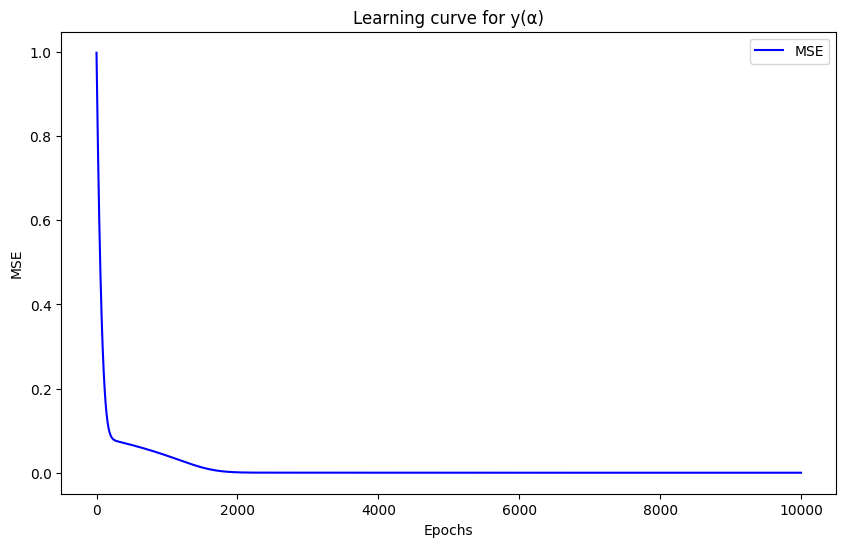

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000108825


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.49997953287113361')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{\alpha\} = \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return b**2/2 - a**2/2

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

2.046712886638602e-05

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0045238710
Epoch [200/5000], Loss: 0.0019023549
Epoch [300/5000], Loss: 0.0010644962
Epoch [400/5000], Loss: 0.0007970850
Epoch [500/5000], Loss: 0.0006457890
Epoch [600/5000], Loss: 0.0005117541
Epoch [700/5000], Loss: 0.0004031424
Epoch [800/5000], Loss: 0.0003198947
Epoch [900/5000], Loss: 0.0002521851
Epoch [1000/5000], Loss: 0.0001952814
Epoch [1100/5000], Loss: 0.0001484955
Epoch [1200/5000], Loss: 0.0001115027
Epoch [1300/5000], Loss: 0.0000833297
Epoch [1400/5000], Loss: 0.0000625010
Epoch [1500/5000], Loss: 0.0000473884
Epoch [1600/5000], Loss: 0.0000364793
Epoch [1700/5000], Loss: 0.0000285261
Epoch [1800/5000], Loss: 0.0000225934
Epoch [1900/5000], Loss: 0.0000180382
Epoch [2000/5000], Loss: 0.0000144528
Epoch [2100/5000], Loss: 0.0000115937
Epoch [2200/5000], Loss: 0.0000093136
Epoch [2300/5000], Loss: 0.0000075103
Epoch [2400/5000], Loss: 0.0000060984
Epoch [2500/5000], Loss: 0.0000050003
Epoch [2600/5000], Loss: 0.0000041470
Epoch [2700/5000], Lo

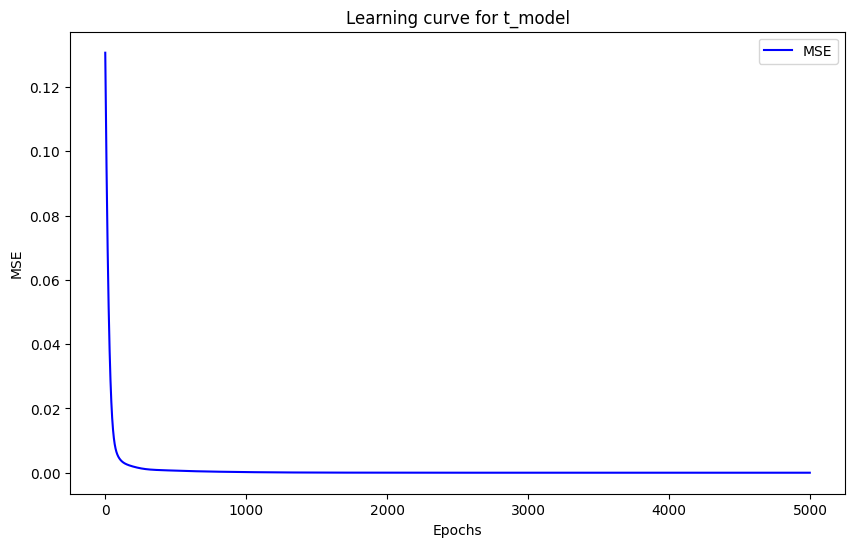

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000001934


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('1.5805934486097319')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 4

In [ ]:
result4 = nn_alpha * nn_t

result4

0.7902643740950679

In [ ]:
correct_result4 = 0.7724589
error_for_result4 = abs(result4 - correct_result4)
error_for_result4

0.01780547409506794

# NN Integration: fifth run

The constants are:

In [ ]:
a_ = 1
b_ = 0
m_ = 3
n_ = 3

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

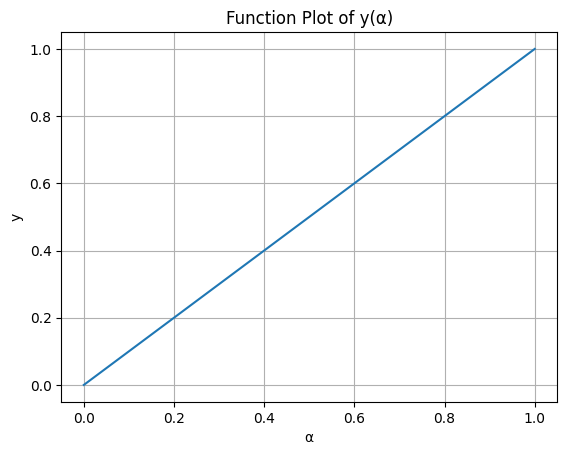

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

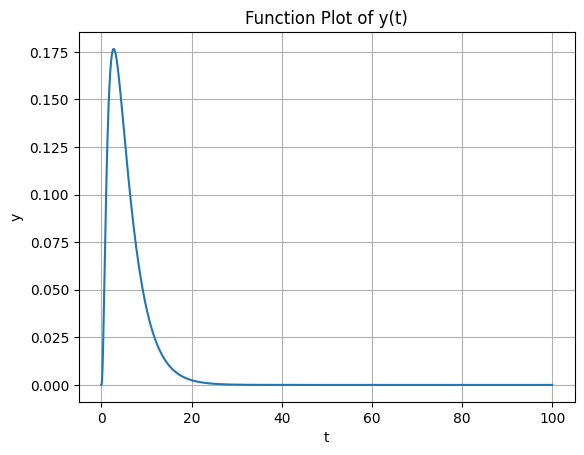

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

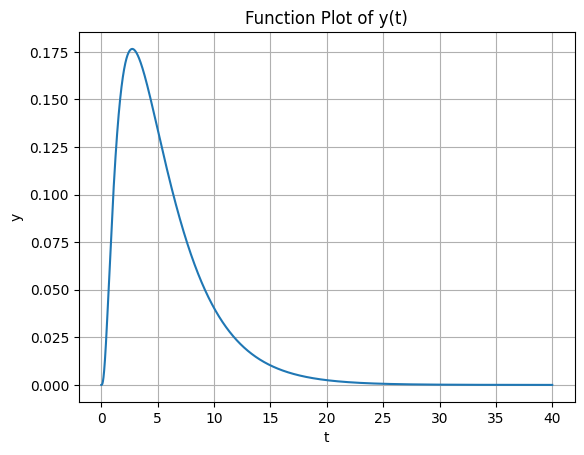

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([34.8535])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

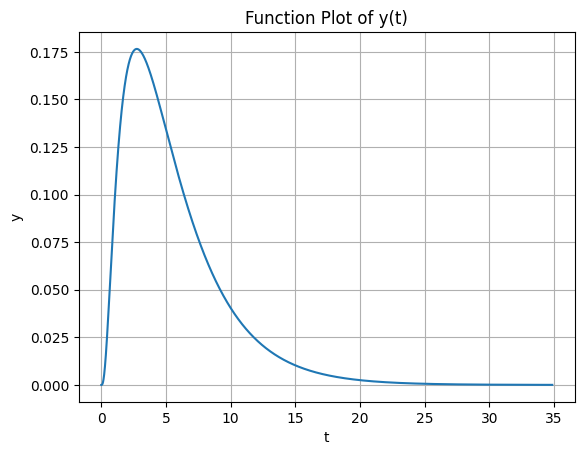

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 34.853485107421875)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

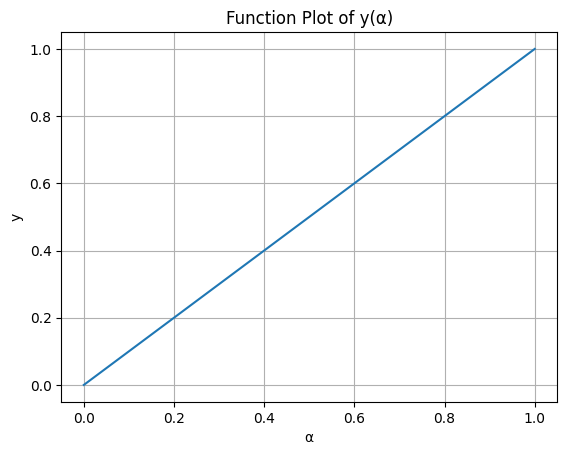

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

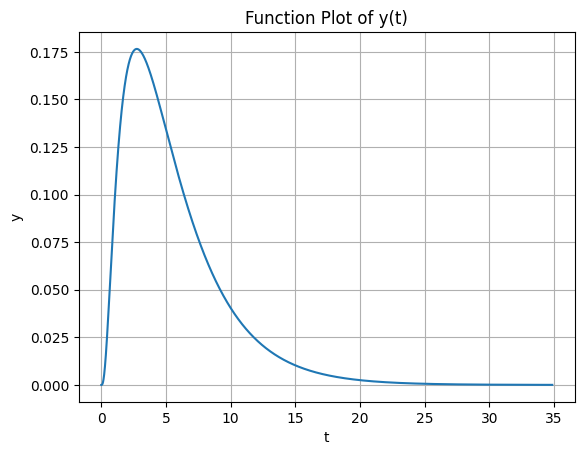

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([3136, 1]),
 torch.Size([349, 1]),
 torch.Size([3136, 1]),
 torch.Size([349, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.0689795688
Epoch [200/10000], Loss: 0.0638993829
Epoch [300/10000], Loss: 0.0592653863
Epoch [400/10000], Loss: 0.0537143648
Epoch [500/10000], Loss: 0.0473016985
Epoch [600/10000], Loss: 0.0401502214
Epoch [700/10000], Loss: 0.0325331576
Epoch [800/10000], Loss: 0.0248981137
Epoch [900/10000], Loss: 0.0178031866
Epoch [1000/10000], Loss: 0.0117736347
Epoch [1100/10000], Loss: 0.0071410066
Epoch [1200/10000], Loss: 0.0039514424
Epoch [1300/10000], Loss: 0.0019945148
Epoch [1400/10000], Loss: 0.0009264685
Epoch [1500/10000], Loss: 0.0004068291
Epoch [1600/10000], Loss: 0.0001802129
Epoch [1700/10000], Loss: 0.0000908673
Epoch [1800/10000], Loss: 0.0000585750
Epoch [1900/10000], Loss: 0.0000475262
Epoch [2000/10000], Loss: 0.0000436089
Epoch [2100/10000], Loss: 0.0000418534
Epoch [2200/10000], Loss: 0.0000406834
Epoch [2300/10000], Loss: 0.0000396487
Epoch [2400/10000], Loss: 0.0000386348
Epoch [2500/10000], Loss: 0.0000376170
Epoch [2600/10000], Loss: 0.000036

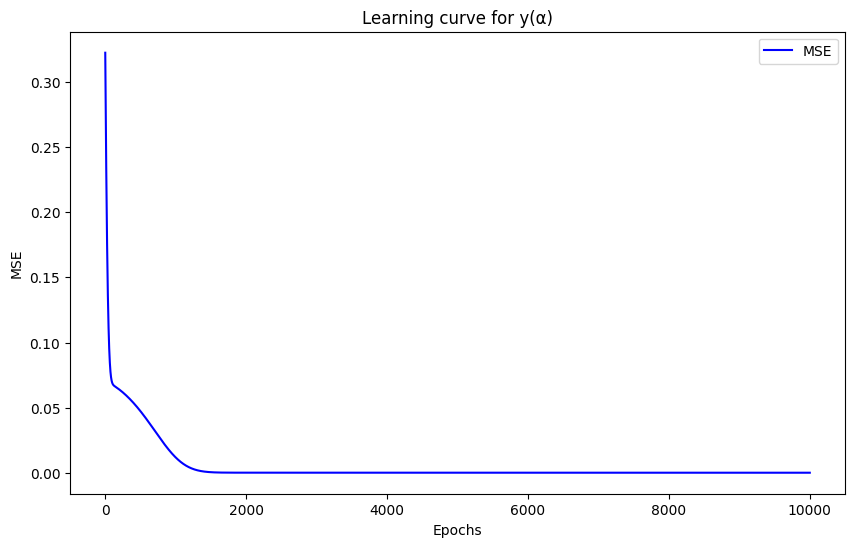

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000067616


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.49999023052190017')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{\alpha\} = \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return b**2/2 - a**2/2

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

9.769478099830309e-06

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0014334364
Epoch [200/5000], Loss: 0.0004121840
Epoch [300/5000], Loss: 0.0000261402
Epoch [400/5000], Loss: 0.0000077673
Epoch [500/5000], Loss: 0.0000070379
Epoch [600/5000], Loss: 0.0000063952
Epoch [700/5000], Loss: 0.0000057982
Epoch [800/5000], Loss: 0.0000052426
Epoch [900/5000], Loss: 0.0000047306
Epoch [1000/5000], Loss: 0.0000042674
Epoch [1100/5000], Loss: 0.0000038571
Epoch [1200/5000], Loss: 0.0000035018
Epoch [1300/5000], Loss: 0.0000032012
Epoch [1400/5000], Loss: 0.0000029525
Epoch [1500/5000], Loss: 0.0000027511
Epoch [1600/5000], Loss: 0.0000025915
Epoch [1700/5000], Loss: 0.0000024674
Epoch [1800/5000], Loss: 0.0000023725
Epoch [1900/5000], Loss: 0.0000023007
Epoch [2000/5000], Loss: 0.0000022468
Epoch [2100/5000], Loss: 0.0000022061
Epoch [2200/5000], Loss: 0.0000021749
Epoch [2300/5000], Loss: 0.0000021504
Epoch [2400/5000], Loss: 0.0000021303
Epoch [2500/5000], Loss: 0.0000021130
Epoch [2600/5000], Loss: 0.0000020975
Epoch [2700/5000], Lo

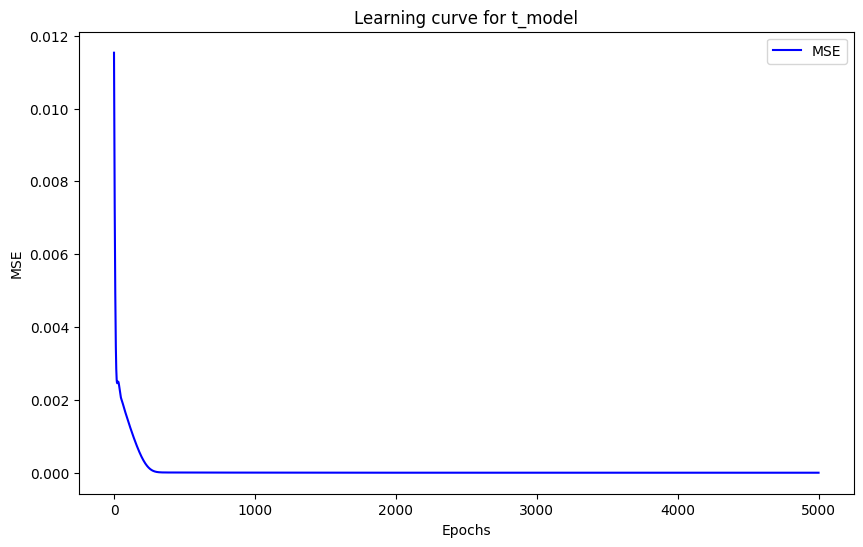

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000031031


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('1.2105484678533189')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 5

In [ ]:
result5 = nn_alpha * nn_t

result5

0.605262407499914

In [ ]:
correct_result5 = 0.5979058
error_for_result5 = abs(result5 - correct_result5)
error_for_result5

0.007356607499913959

# NN Integration: sixth run

The constants are:

In [ ]:
a_ = 0
b_ = 0
m_ = 2
n_ = 3

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

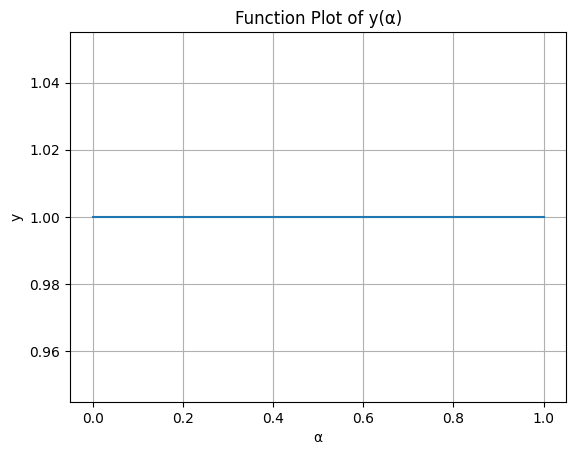

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

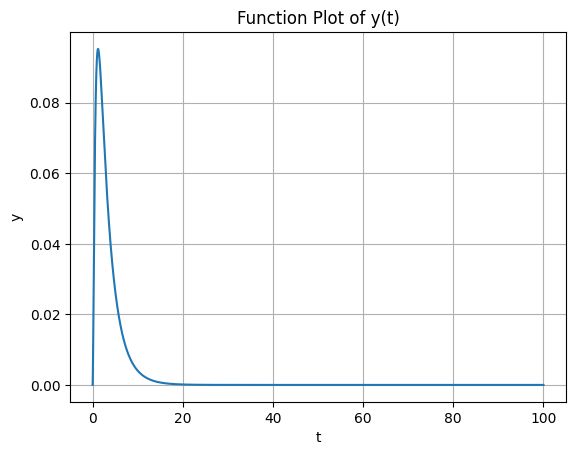

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

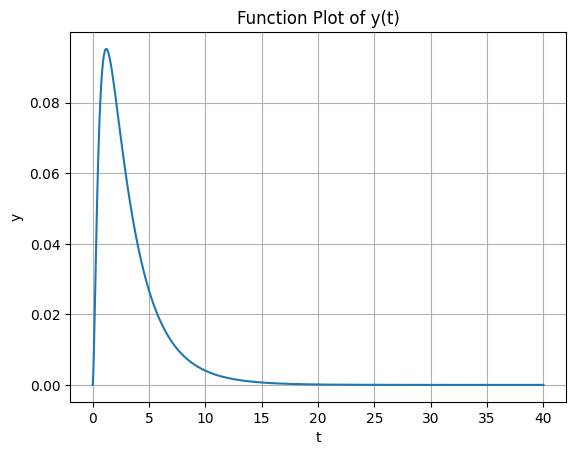

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([24.2524])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

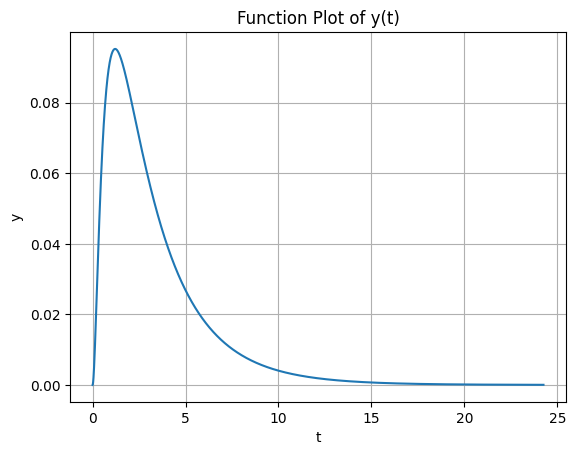

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 24.252424240112305)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

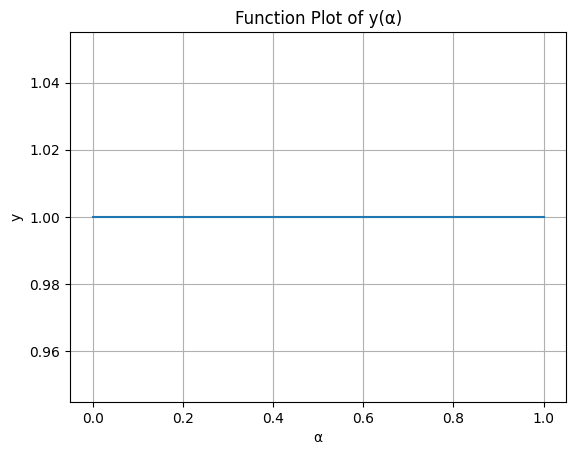

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

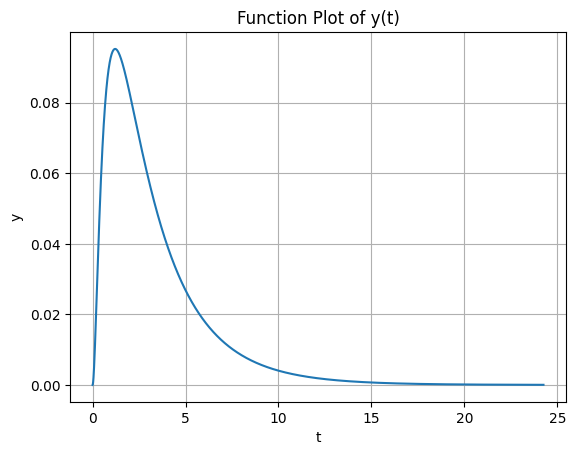

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([2182, 1]),
 torch.Size([243, 1]),
 torch.Size([2182, 1]),
 torch.Size([243, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.4405039549
Epoch [200/10000], Loss: 0.0831364170
Epoch [300/10000], Loss: 0.0089761969
Epoch [400/10000], Loss: 0.0005311082
Epoch [500/10000], Loss: 0.0000263366
Epoch [600/10000], Loss: 0.0000098508
Epoch [700/10000], Loss: 0.0000091486
Epoch [800/10000], Loss: 0.0000087014
Epoch [900/10000], Loss: 0.0000082467
Epoch [1000/10000], Loss: 0.0000077882
Epoch [1100/10000], Loss: 0.0000073308
Epoch [1200/10000], Loss: 0.0000068799
Epoch [1300/10000], Loss: 0.0000064396
Epoch [1400/10000], Loss: 0.0000060131
Epoch [1500/10000], Loss: 0.0000056044
Epoch [1600/10000], Loss: 0.0000052171
Epoch [1700/10000], Loss: 0.0000048530
Epoch [1800/10000], Loss: 0.0000045137
Epoch [1900/10000], Loss: 0.0000042005
Epoch [2000/10000], Loss: 0.0000039143
Epoch [2100/10000], Loss: 0.0000036554
Epoch [2200/10000], Loss: 0.0000034230
Epoch [2300/10000], Loss: 0.0000032167
Epoch [2400/10000], Loss: 0.0000030357
Epoch [2500/10000], Loss: 0.0000028781
Epoch [2600/10000], Loss: 0.000002

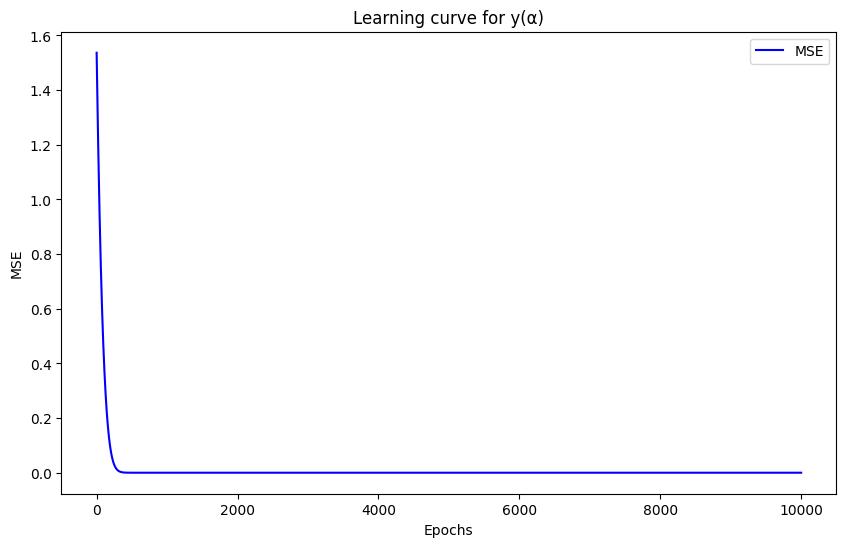

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000010072


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('1.0000018540005744')], dtype=object)

It's easy to get this integral analytically $\int d\alpha = \alpha $, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return 1

alpha_actual = int_alpha(0, 1)

alpha_actual

1

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

1.8540005743972188e-06

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0261106379
Epoch [200/5000], Loss: 0.0016110244
Epoch [300/5000], Loss: 0.0002638870
Epoch [400/5000], Loss: 0.0001882828
Epoch [500/5000], Loss: 0.0001717964
Epoch [600/5000], Loss: 0.0001581145
Epoch [700/5000], Loss: 0.0001460480
Epoch [800/5000], Loss: 0.0001353531
Epoch [900/5000], Loss: 0.0001257540
Epoch [1000/5000], Loss: 0.0001170157
Epoch [1100/5000], Loss: 0.0001089735
Epoch [1200/5000], Loss: 0.0001015326
Epoch [1300/5000], Loss: 0.0000946497
Epoch [1400/5000], Loss: 0.0000883125
Epoch [1500/5000], Loss: 0.0000825197
Epoch [1600/5000], Loss: 0.0000772681
Epoch [1700/5000], Loss: 0.0000725452
Epoch [1800/5000], Loss: 0.0000683243
Epoch [1900/5000], Loss: 0.0000645655
Epoch [2000/5000], Loss: 0.0000612167
Epoch [2100/5000], Loss: 0.0000582182
Epoch [2200/5000], Loss: 0.0000555066
Epoch [2300/5000], Loss: 0.0000530194
Epoch [2400/5000], Loss: 0.0000506994
Epoch [2500/5000], Loss: 0.0000484972
Epoch [2600/5000], Loss: 0.0000463732
Epoch [2700/5000], Lo

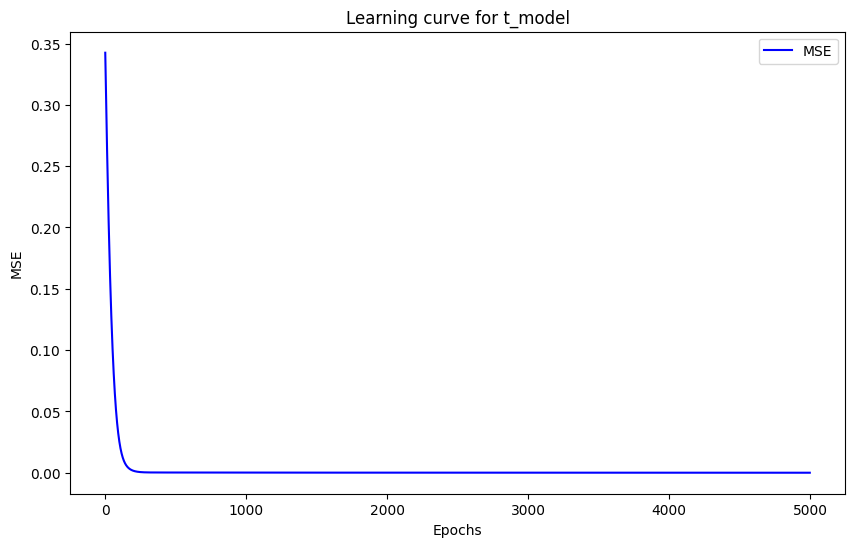

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000156761


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('0.37013036281584277')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 6

In [ ]:
result6 = nn_alpha * nn_t

result6

0.370131049037748

In [ ]:
correct_result6 = 0.3491064
error_for_result6 = abs(result6 - correct_result6)
error_for_result6

0.021024649037748033

# NN Integration: seventh run

The constants are:

In [ ]:
a_ = 0
b_ = 1
m_ = 2
n_ = 3

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

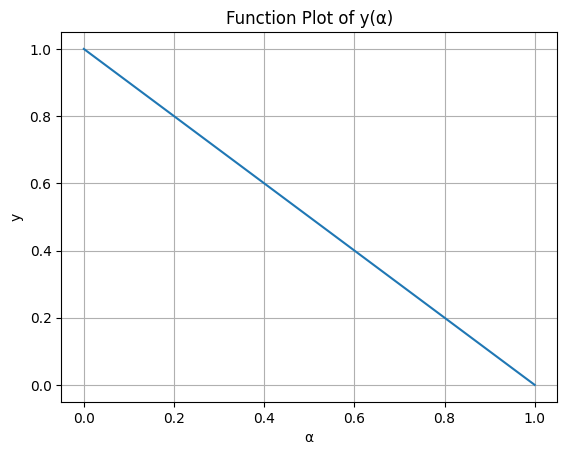

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

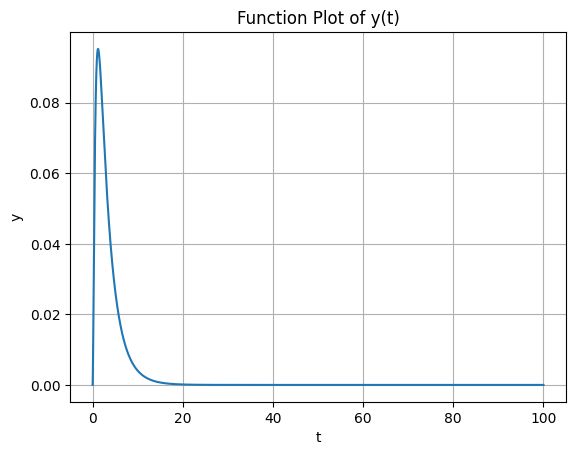

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

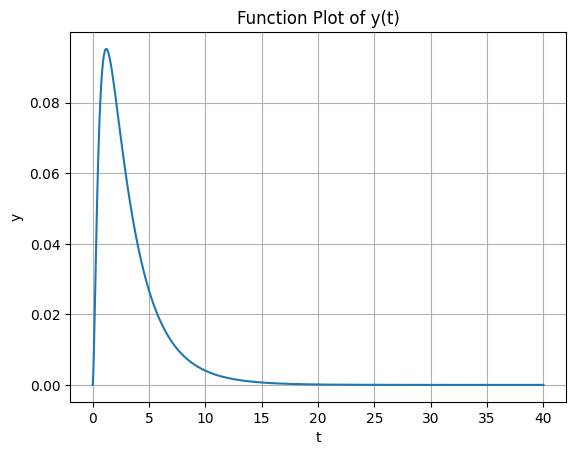

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([24.2524])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

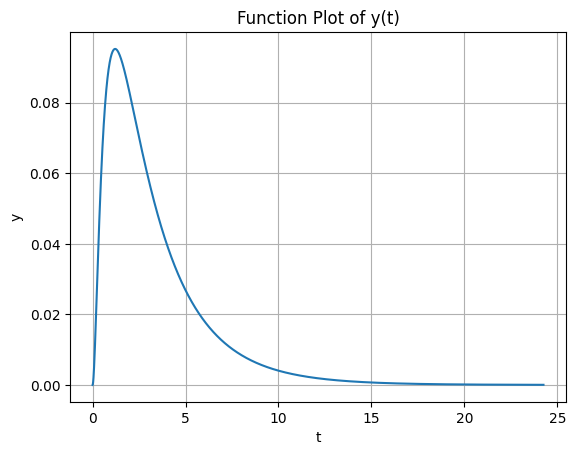

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 24.252424240112305)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

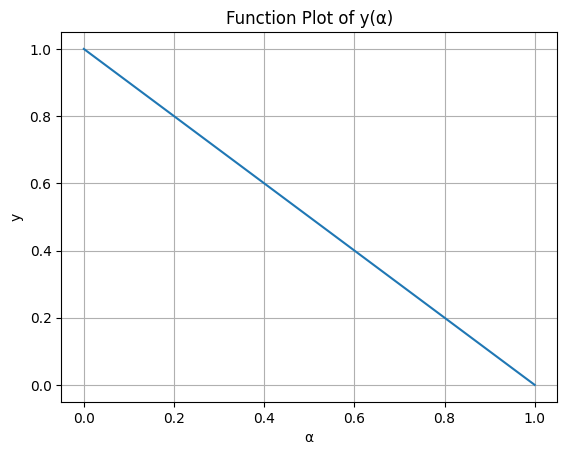

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

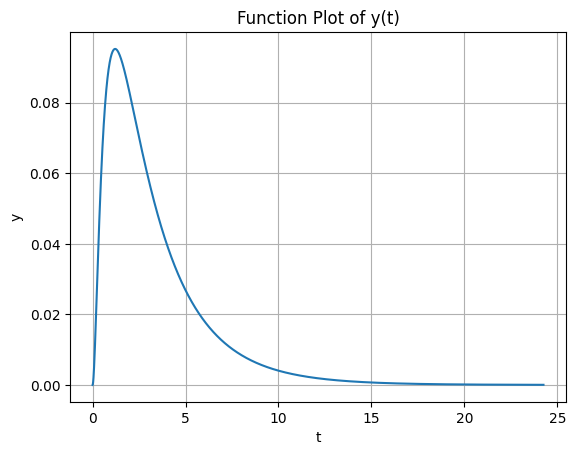

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([2182, 1]),
 torch.Size([243, 1]),
 torch.Size([2182, 1]),
 torch.Size([243, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.1179431081
Epoch [200/10000], Loss: 0.0668818653
Epoch [300/10000], Loss: 0.0602602623
Epoch [400/10000], Loss: 0.0542749763
Epoch [500/10000], Loss: 0.0480453447
Epoch [600/10000], Loss: 0.0416075699
Epoch [700/10000], Loss: 0.0350530781
Epoch [800/10000], Loss: 0.0285417922
Epoch [900/10000], Loss: 0.0223016068
Epoch [1000/10000], Loss: 0.0166002829
Epoch [1100/10000], Loss: 0.0116906650
Epoch [1200/10000], Loss: 0.0077462038
Epoch [1300/10000], Loss: 0.0048142779
Epoch [1400/10000], Loss: 0.0028103862
Epoch [1500/10000], Loss: 0.0015555370
Epoch [1600/10000], Loss: 0.0008362563
Epoch [1700/10000], Loss: 0.0004582421
Epoch [1800/10000], Loss: 0.0002752935
Epoch [1900/10000], Loss: 0.0001930713
Epoch [2000/10000], Loss: 0.0001581364
Epoch [2100/10000], Loss: 0.0001434853
Epoch [2200/10000], Loss: 0.0001367992
Epoch [2300/10000], Loss: 0.0001329618
Epoch [2400/10000], Loss: 0.0001300292
Epoch [2500/10000], Loss: 0.0001273252
Epoch [2600/10000], Loss: 0.000124

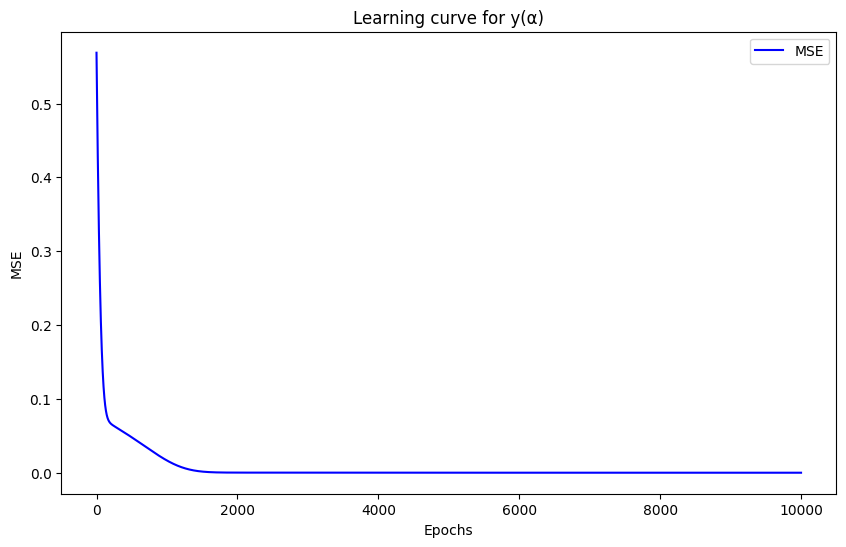

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000071822


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.50001028333868369')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{1 - \alpha\} = \alpha - \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return b - b**2/2 - (a - a**2/2)

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

1.0283338683692023e-05

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0001232421
Epoch [200/5000], Loss: 0.0000968315
Epoch [300/5000], Loss: 0.0000891467
Epoch [400/5000], Loss: 0.0000826516
Epoch [500/5000], Loss: 0.0000769416
Epoch [600/5000], Loss: 0.0000718194
Epoch [700/5000], Loss: 0.0000671758
Epoch [800/5000], Loss: 0.0000629874
Epoch [900/5000], Loss: 0.0000592644
Epoch [1000/5000], Loss: 0.0000560130
Epoch [1100/5000], Loss: 0.0000532193
Epoch [1200/5000], Loss: 0.0000508492
Epoch [1300/5000], Loss: 0.0000488537
Epoch [1400/5000], Loss: 0.0000471758
Epoch [1500/5000], Loss: 0.0000457571
Epoch [1600/5000], Loss: 0.0000445423
Epoch [1700/5000], Loss: 0.0000434823
Epoch [1800/5000], Loss: 0.0000425364
Epoch [1900/5000], Loss: 0.0000416721
Epoch [2000/5000], Loss: 0.0000408647
Epoch [2100/5000], Loss: 0.0000400964
Epoch [2200/5000], Loss: 0.0000393544
Epoch [2300/5000], Loss: 0.0000386302
Epoch [2400/5000], Loss: 0.0000379180
Epoch [2500/5000], Loss: 0.0000372137
Epoch [2600/5000], Loss: 0.0000365145
Epoch [2700/5000], Lo

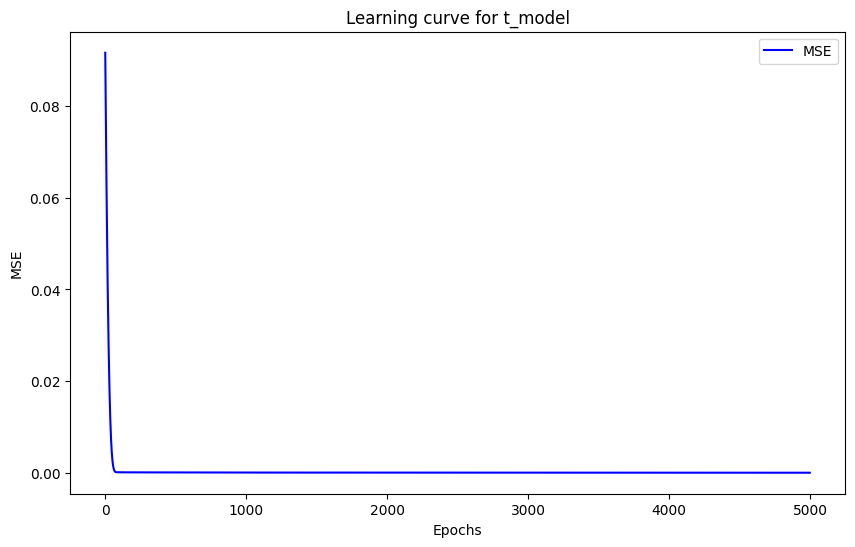

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000219977


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('0.37125040409693')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 7

In [ ]:
result7 = nn_alpha * nn_t

result7

0.1856290197421068

In [ ]:
correct_result7 = 0.1745532
error_for_result7 = abs(result7 - correct_result7)
error_for_result7

0.011075819742106807

# NN Integration: eith run

The constants are:

In [ ]:
a_ = 1
b_ = 0
m_ = 2
n_ = 3

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

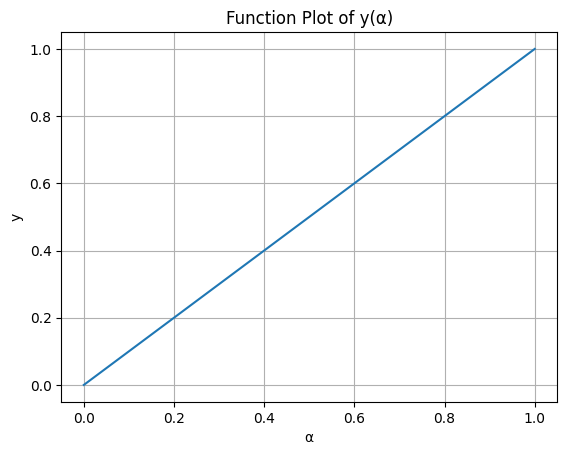

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

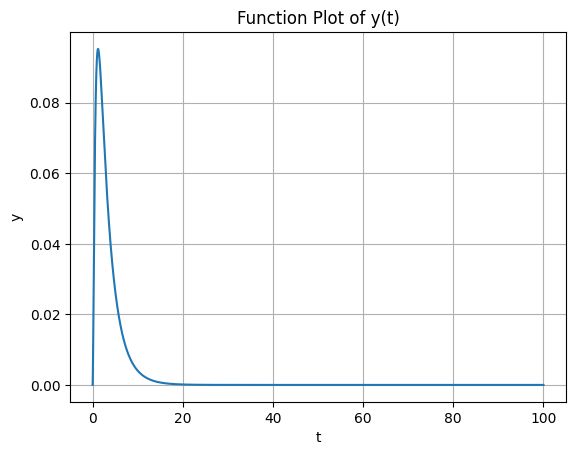

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

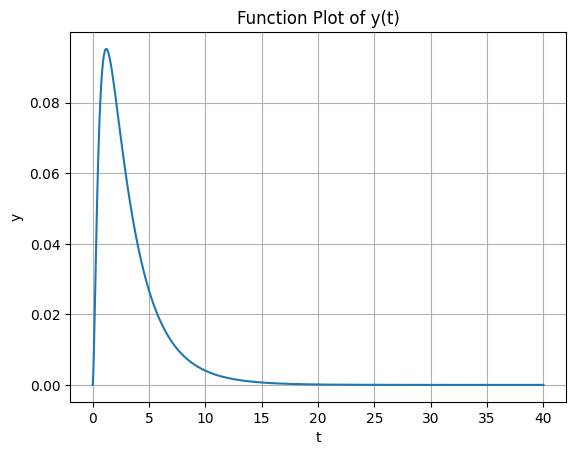

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([24.2524])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

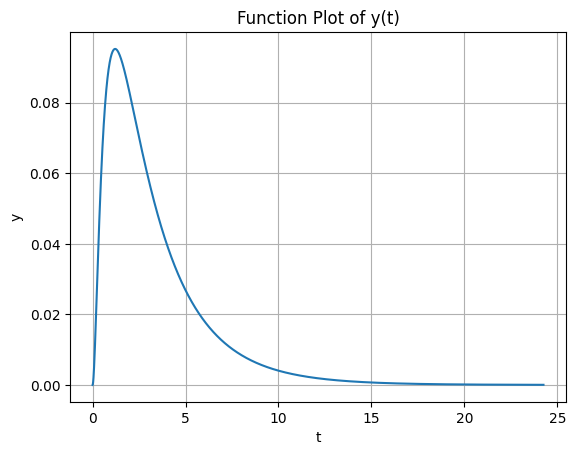

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 24.252424240112305)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

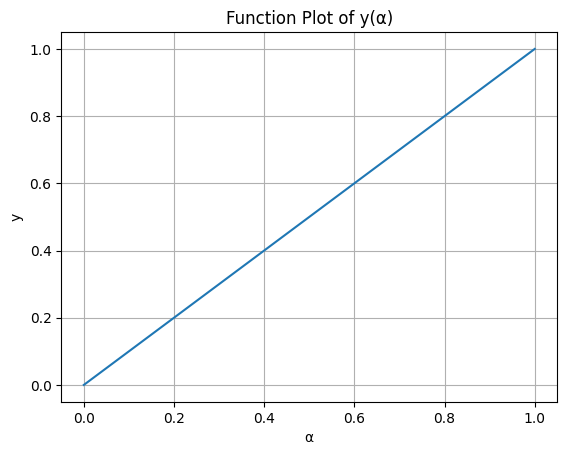

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

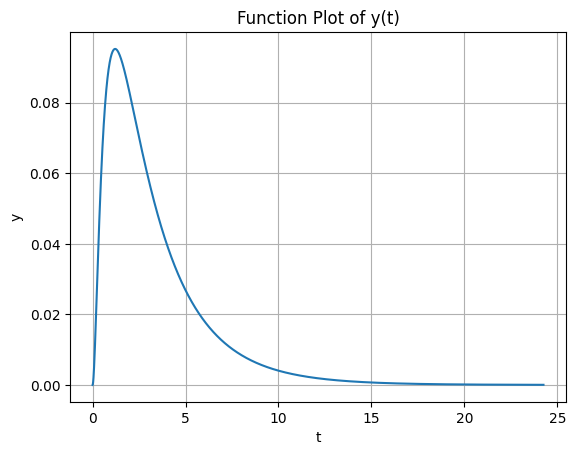

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([2182, 1]),
 torch.Size([243, 1]),
 torch.Size([2182, 1]),
 torch.Size([243, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.0809807852
Epoch [200/10000], Loss: 0.0608113743
Epoch [300/10000], Loss: 0.0566646419
Epoch [400/10000], Loss: 0.0520373061
Epoch [500/10000], Loss: 0.0469907038
Epoch [600/10000], Loss: 0.0415950939
Epoch [700/10000], Loss: 0.0359349847
Epoch [800/10000], Loss: 0.0301350448
Epoch [900/10000], Loss: 0.0243729111
Epoch [1000/10000], Loss: 0.0188744348
Epoch [1100/10000], Loss: 0.0138874454
Epoch [1200/10000], Loss: 0.0096351188
Epoch [1300/10000], Loss: 0.0062619750
Epoch [1400/10000], Loss: 0.0037955430
Epoch [1500/10000], Loss: 0.0021446997
Epoch [1600/10000], Loss: 0.0011373623
Epoch [1700/10000], Loss: 0.0005775108
Epoch [1800/10000], Loss: 0.0002935696
Epoch [1900/10000], Loss: 0.0001615768
Epoch [2000/10000], Loss: 0.0001049284
Epoch [2100/10000], Loss: 0.0000821801
Epoch [2200/10000], Loss: 0.0000733540
Epoch [2300/10000], Loss: 0.0000697626
Epoch [2400/10000], Loss: 0.0000679674
Epoch [2500/10000], Loss: 0.0000667230
Epoch [2600/10000], Loss: 0.000065

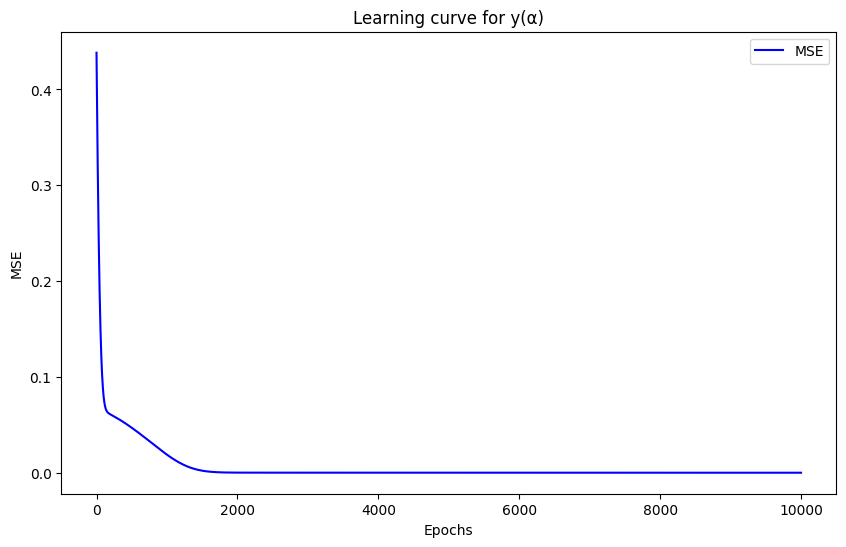

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000041855


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.5000176982206197')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{\alpha\} = \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return b**2/2 - a**2/2

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

1.769822061969961e-05

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0009677251
Epoch [200/5000], Loss: 0.0001721492
Epoch [300/5000], Loss: 0.0000930017
Epoch [400/5000], Loss: 0.0000608752
Epoch [500/5000], Loss: 0.0000464113
Epoch [600/5000], Loss: 0.0000390025
Epoch [700/5000], Loss: 0.0000345857
Epoch [800/5000], Loss: 0.0000315303
Epoch [900/5000], Loss: 0.0000291435
Epoch [1000/5000], Loss: 0.0000271071
Epoch [1100/5000], Loss: 0.0000252633
Epoch [1200/5000], Loss: 0.0000235277
Epoch [1300/5000], Loss: 0.0000218545
Epoch [1400/5000], Loss: 0.0000202200
Epoch [1500/5000], Loss: 0.0000186156
Epoch [1600/5000], Loss: 0.0000170434
Epoch [1700/5000], Loss: 0.0000155128
Epoch [1800/5000], Loss: 0.0000140370
Epoch [1900/5000], Loss: 0.0000126303
Epoch [2000/5000], Loss: 0.0000113062
Epoch [2100/5000], Loss: 0.0000100753
Epoch [2200/5000], Loss: 0.0000089453
Epoch [2300/5000], Loss: 0.0000079196
Epoch [2400/5000], Loss: 0.0000069982
Epoch [2500/5000], Loss: 0.0000061773
Epoch [2600/5000], Loss: 0.0000054506
Epoch [2700/5000], Lo

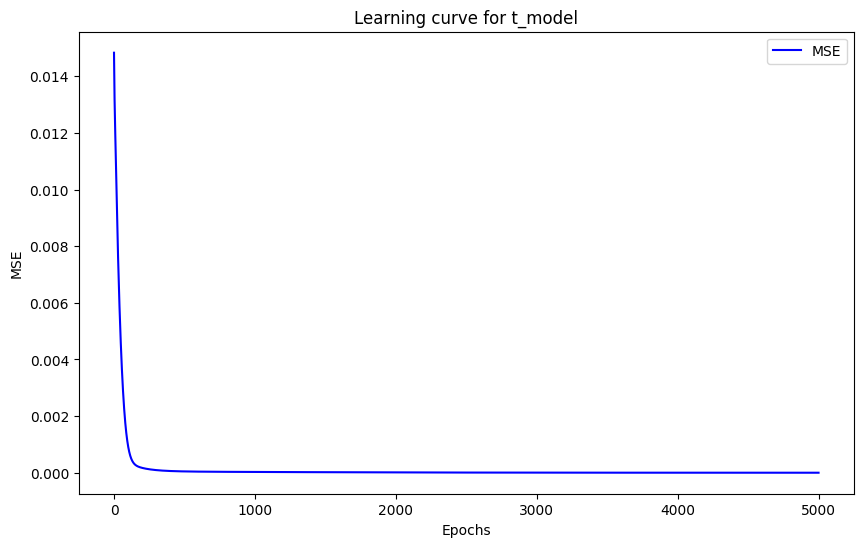

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000002849


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('0.37021140290933907')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 8

In [ ]:
result8 = nn_alpha * nn_t

result8

0.18511225353775415

In [ ]:
correct_result8 = 0.1745532
error_for_result8 = abs(result8 - correct_result8)
error_for_result8

0.01055905353775416

# NN Integration: ninth run

The constants are:

In [ ]:
a_ = 1
b_ = 1
m_ = 2
n_ = 3

## Dataset (1.1)

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

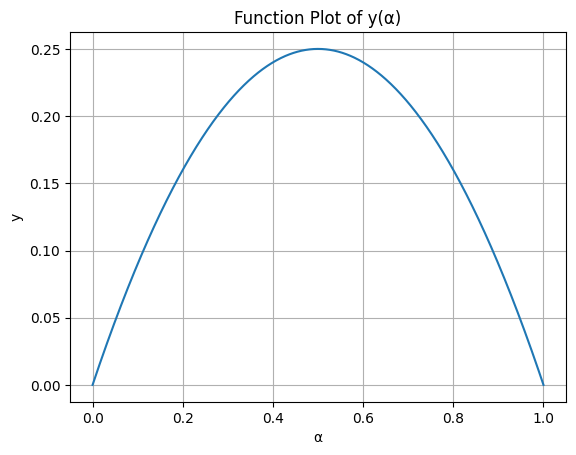

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

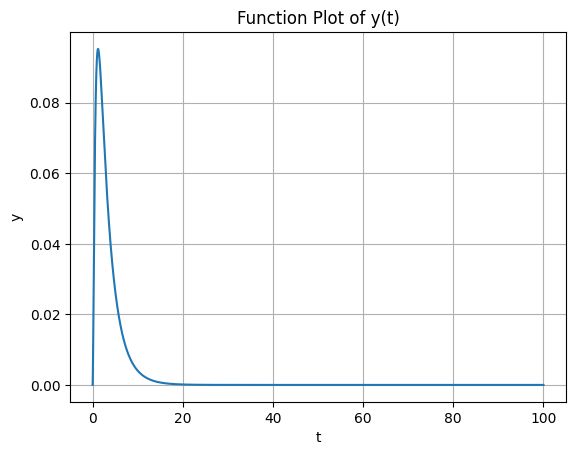

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

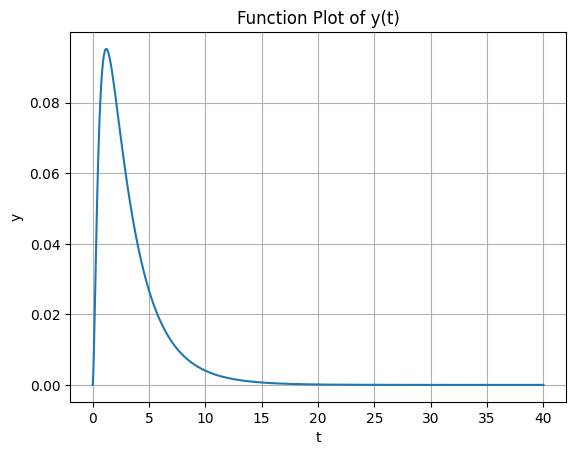

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [ ]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [ ]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([24.2524])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [ ]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

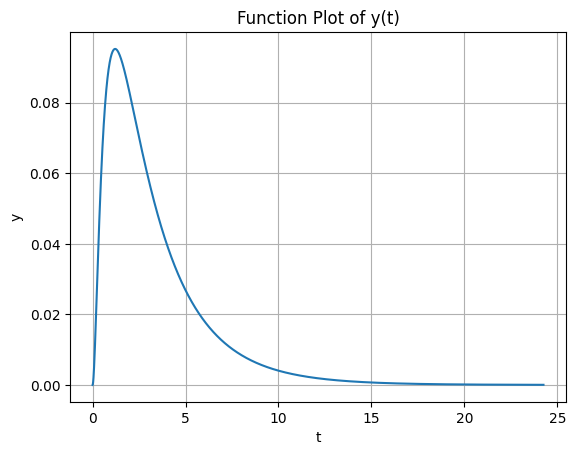

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [ ]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 24.252424240112305)

## Datasets based on bounds

In [ ]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=2000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

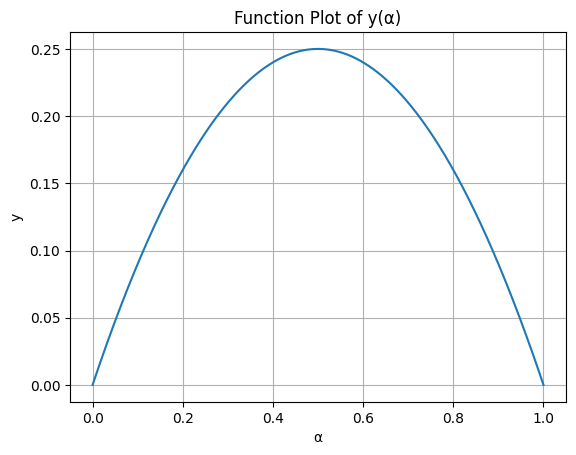

In [ ]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

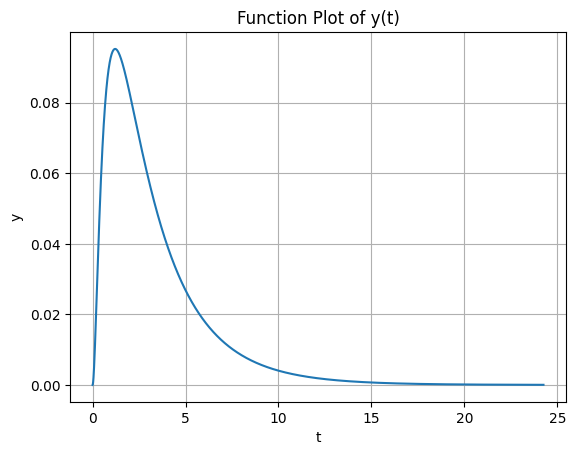

In [ ]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Train-test datasets split

In [ ]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [ ]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([1800, 1]),
 torch.Size([200, 1]),
 torch.Size([1800, 1]),
 torch.Size([200, 1]))

In [ ]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([2182, 1]),
 torch.Size([243, 1]),
 torch.Size([2182, 1]),
 torch.Size([243, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [ ]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.0191328172
Epoch [200/10000], Loss: 0.0059685470
Epoch [300/10000], Loss: 0.0059302156
Epoch [400/10000], Loss: 0.0059026517
Epoch [500/10000], Loss: 0.0058734505
Epoch [600/10000], Loss: 0.0058436915
Epoch [700/10000], Loss: 0.0058142478
Epoch [800/10000], Loss: 0.0057858168
Epoch [900/10000], Loss: 0.0057589421
Epoch [1000/10000], Loss: 0.0057340199
Epoch [1100/10000], Loss: 0.0057113161
Epoch [1200/10000], Loss: 0.0056909770
Epoch [1300/10000], Loss: 0.0056730444
Epoch [1400/10000], Loss: 0.0056574699
Epoch [1500/10000], Loss: 0.0056441338
Epoch [1600/10000], Loss: 0.0056328615
Epoch [1700/10000], Loss: 0.0056234370
Epoch [1800/10000], Loss: 0.0056156218
Epoch [1900/10000], Loss: 0.0056091705
Epoch [2000/10000], Loss: 0.0056038424
Epoch [2100/10000], Loss: 0.0055994079
Epoch [2200/10000], Loss: 0.0055956617
Epoch [2300/10000], Loss: 0.0055924244
Epoch [2400/10000], Loss: 0.0055895392
Epoch [2500/10000], Loss: 0.0055868807
Epoch [2600/10000], Loss: 0.005584

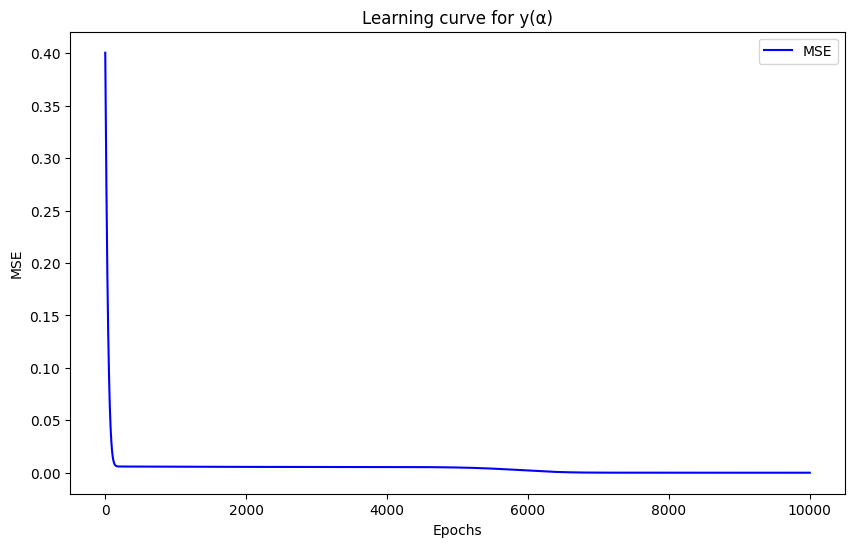

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [ ]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000416421


## alpha_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.16662236476980685')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{\alpha(1 - \alpha)\} = \frac{\alpha^2}{2} - \frac{\alpha^3}{3}$, so the actual definite integral value is:

In [ ]:
def int_alpha(a, b):
    return b**2/2 - b**3/3 - (a**2/2 - a**3/3)

alpha_actual = int_alpha(0, 1)

alpha_actual

0.16666666666666669

And the error is:

In [ ]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

4.430189685983299e-05

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [ ]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [ ]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0044925562
Epoch [200/5000], Loss: 0.0010007053
Epoch [300/5000], Loss: 0.0005159004
Epoch [400/5000], Loss: 0.0002384589
Epoch [500/5000], Loss: 0.0001143418
Epoch [600/5000], Loss: 0.0000795687
Epoch [700/5000], Loss: 0.0000727763
Epoch [800/5000], Loss: 0.0000711713
Epoch [900/5000], Loss: 0.0000701711
Epoch [1000/5000], Loss: 0.0000691716
Epoch [1100/5000], Loss: 0.0000681163
Epoch [1200/5000], Loss: 0.0000670013
Epoch [1300/5000], Loss: 0.0000658260
Epoch [1400/5000], Loss: 0.0000645896
Epoch [1500/5000], Loss: 0.0000632913
Epoch [1600/5000], Loss: 0.0000619299
Epoch [1700/5000], Loss: 0.0000605043
Epoch [1800/5000], Loss: 0.0000590135
Epoch [1900/5000], Loss: 0.0000574564
Epoch [2000/5000], Loss: 0.0000558320
Epoch [2100/5000], Loss: 0.0000541398
Epoch [2200/5000], Loss: 0.0000523793
Epoch [2300/5000], Loss: 0.0000505508
Epoch [2400/5000], Loss: 0.0000486551
Epoch [2500/5000], Loss: 0.0000466941
Epoch [2600/5000], Loss: 0.0000446712
Epoch [2700/5000], Lo

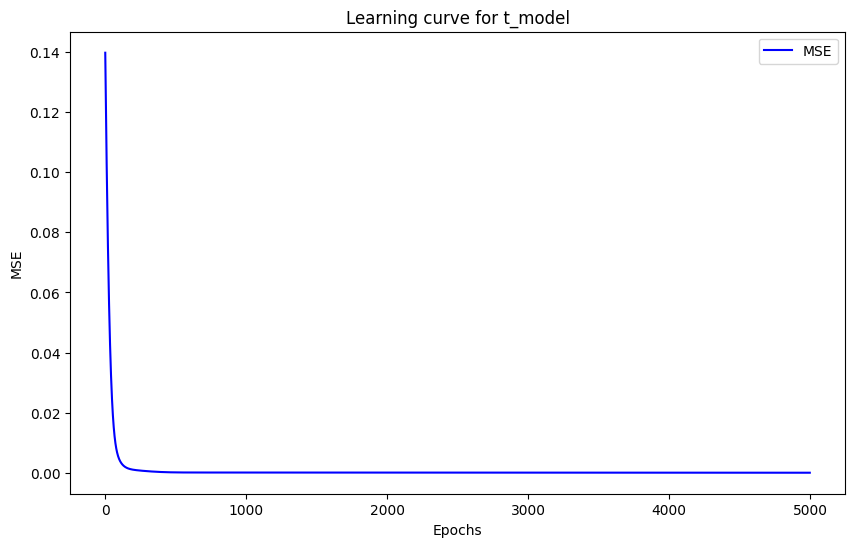

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [ ]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000076752


## t_model usage

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [ ]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('0.37052614684446361')], dtype=object)

In [ ]:
nn_t = float(nn_t[0])

## Result 9

In [ ]:
result9 = nn_alpha * nn_t

result9

0.061737942796269235

In [ ]:
correct_result9 = 6.8729743E-02
error_for_result9 = abs(result9 - correct_result9)
error_for_result9

0.006991800203730761

# Results graphs

In [ ]:
results = [result1, result2, result3, result4, result5, result6, result7, result8, result9]
correct_results = [correct_result1, correct_result2, correct_result3, correct_result4, correct_result5, correct_result6, correct_result7, correct_result8, correct_result9]

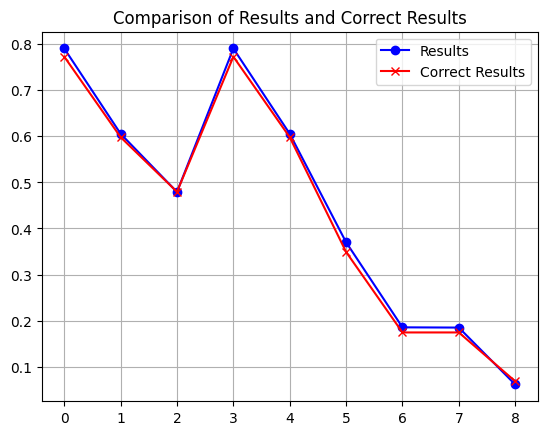

In [ ]:
plt.plot(results, label='Results', color='blue', marker='o')
plt.plot(correct_results, label='Correct Results', color='red', marker='x')
plt.title('Comparison of Results and Correct Results')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
errors = [error_for_result1, error_for_result2, error_for_result3, 
          error_for_result4, error_for_result5, error_for_result6, 
          error_for_result7, error_for_result8, error_for_result9]

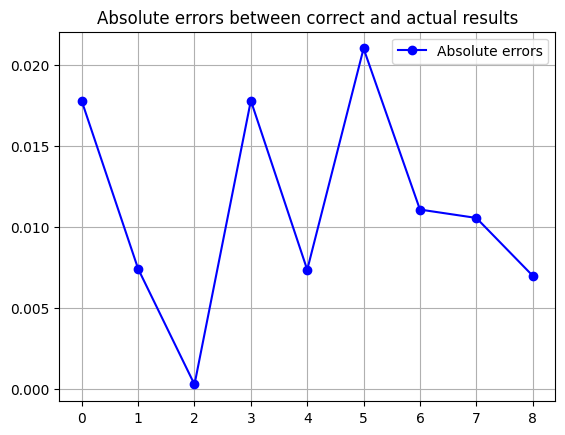

In [ ]:
plt.plot(errors, label='Absolute errors', color='blue', marker='o')
plt.title('Absolute errors between correct and actual results')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
results, correct_results, errors

([0.7902330614621713,
  0.6053219505675683,
  0.4791625369302108,
  0.7902643740950679,
  0.605262407499914,
  0.370131049037748,
  0.1856290197421068,
  0.18511225353775415,
  0.061737942796269235],
 [0.772459,
  0.5979058,
  0.4794361,
  0.7724589,
  0.5979058,
  0.3491064,
  0.1745532,
  0.1745532,
  0.068729743],
 [0.01777406146217131,
  0.00741615056756828,
  0.0002735630697891511,
  0.01780547409506794,
  0.007356607499913959,
  0.021024649037748033,
  0.011075819742106807,
  0.01055905353775416,
  0.006991800203730761])